## 1-D Classification - Only Feature Divergences

EXPERIMENT 1: Delta (Mean) Shift (10 repeats)


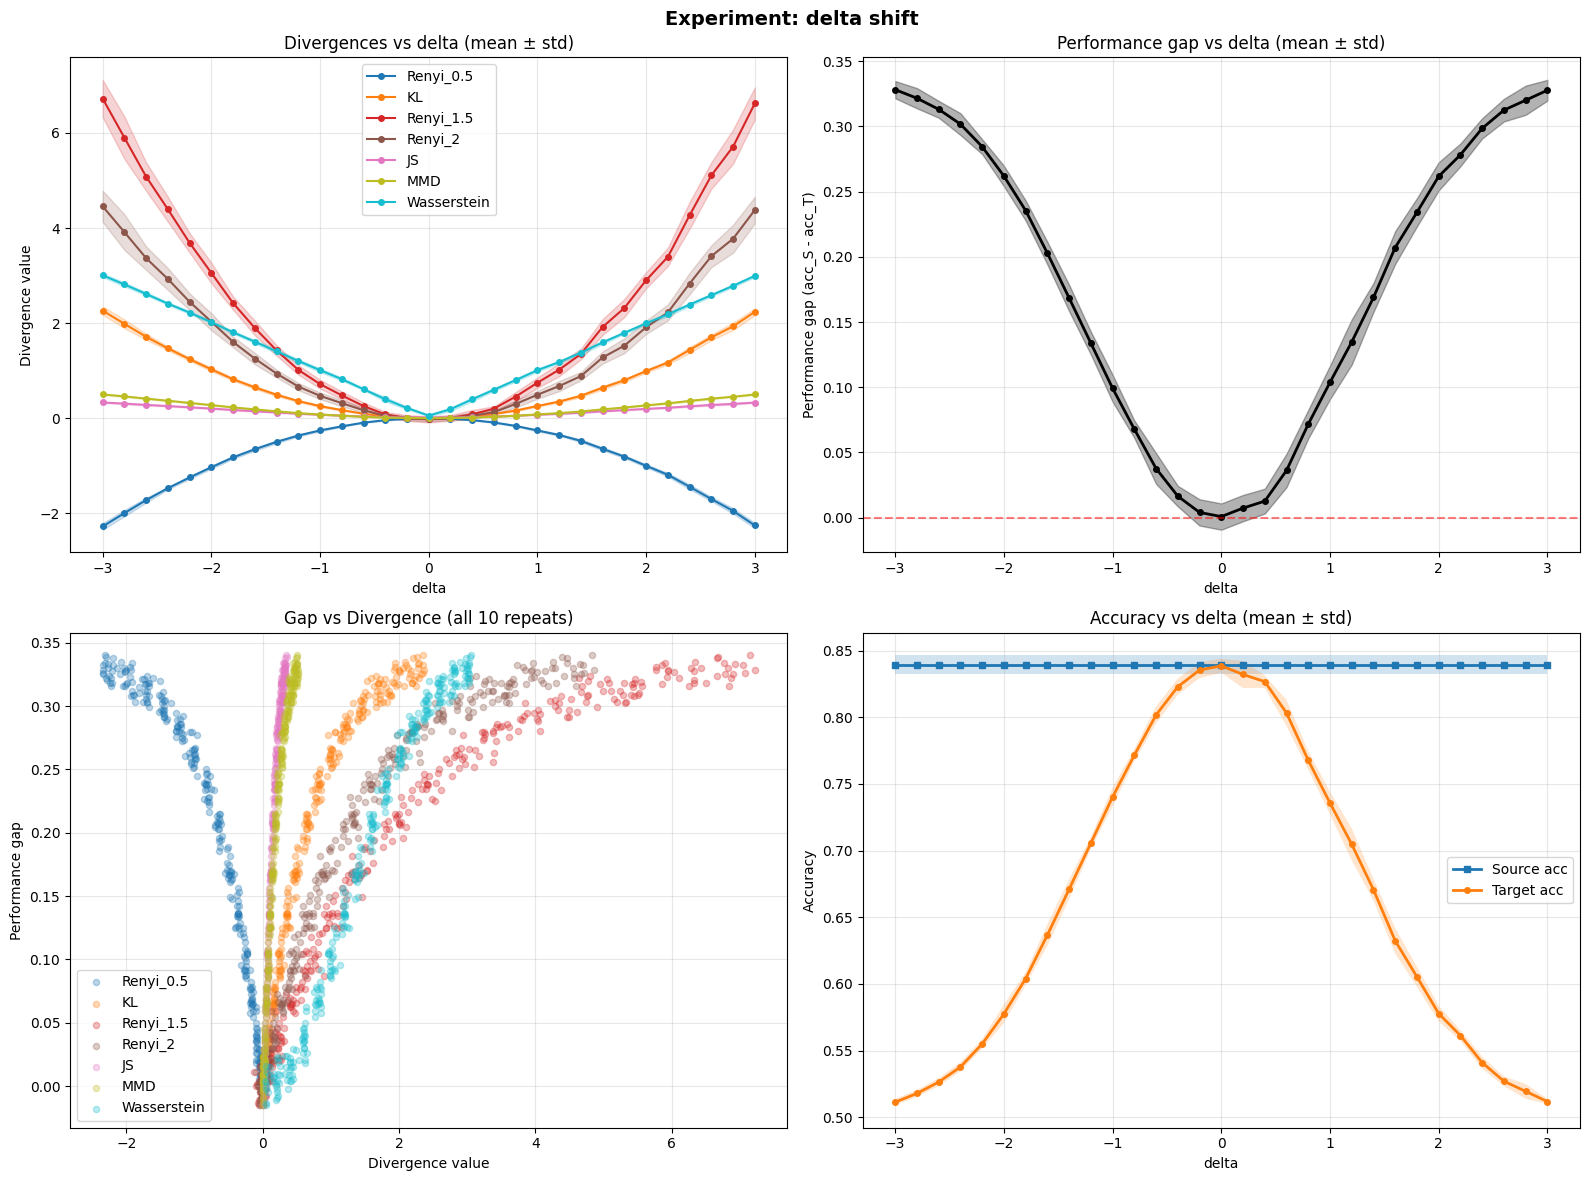


Aggregated results (first 10 rows):
           gap                  KL                  JS                 MMD  \
          mean       std      mean       std      mean       std      mean   
param                                                                        
-3.0   0.32810  0.006595  2.263120  0.085725  0.331059  0.010989  0.500522   
-2.8   0.32155  0.007758  1.985545  0.091843  0.306629  0.015071  0.458499   
-2.6   0.31305  0.006470  1.712794  0.064055  0.279471  0.014315  0.412576   
-2.4   0.30170  0.008374  1.469469  0.041656  0.255599  0.011513  0.367132   
-2.2   0.28440  0.005685  1.241161  0.038239  0.228992  0.010997  0.321856   
-2.0   0.26190  0.007884  1.027458  0.040794  0.203154  0.012083  0.275467   
-1.8   0.23545  0.007722  0.819620  0.030207  0.172944  0.010238  0.227018   
-1.6   0.20275  0.008709  0.648019  0.032810  0.146359  0.008732  0.185618   
-1.4   0.16840  0.010102  0.493166  0.029431  0.120136  0.007454  0.144948   
-1.2   0.13380  0.008772  0

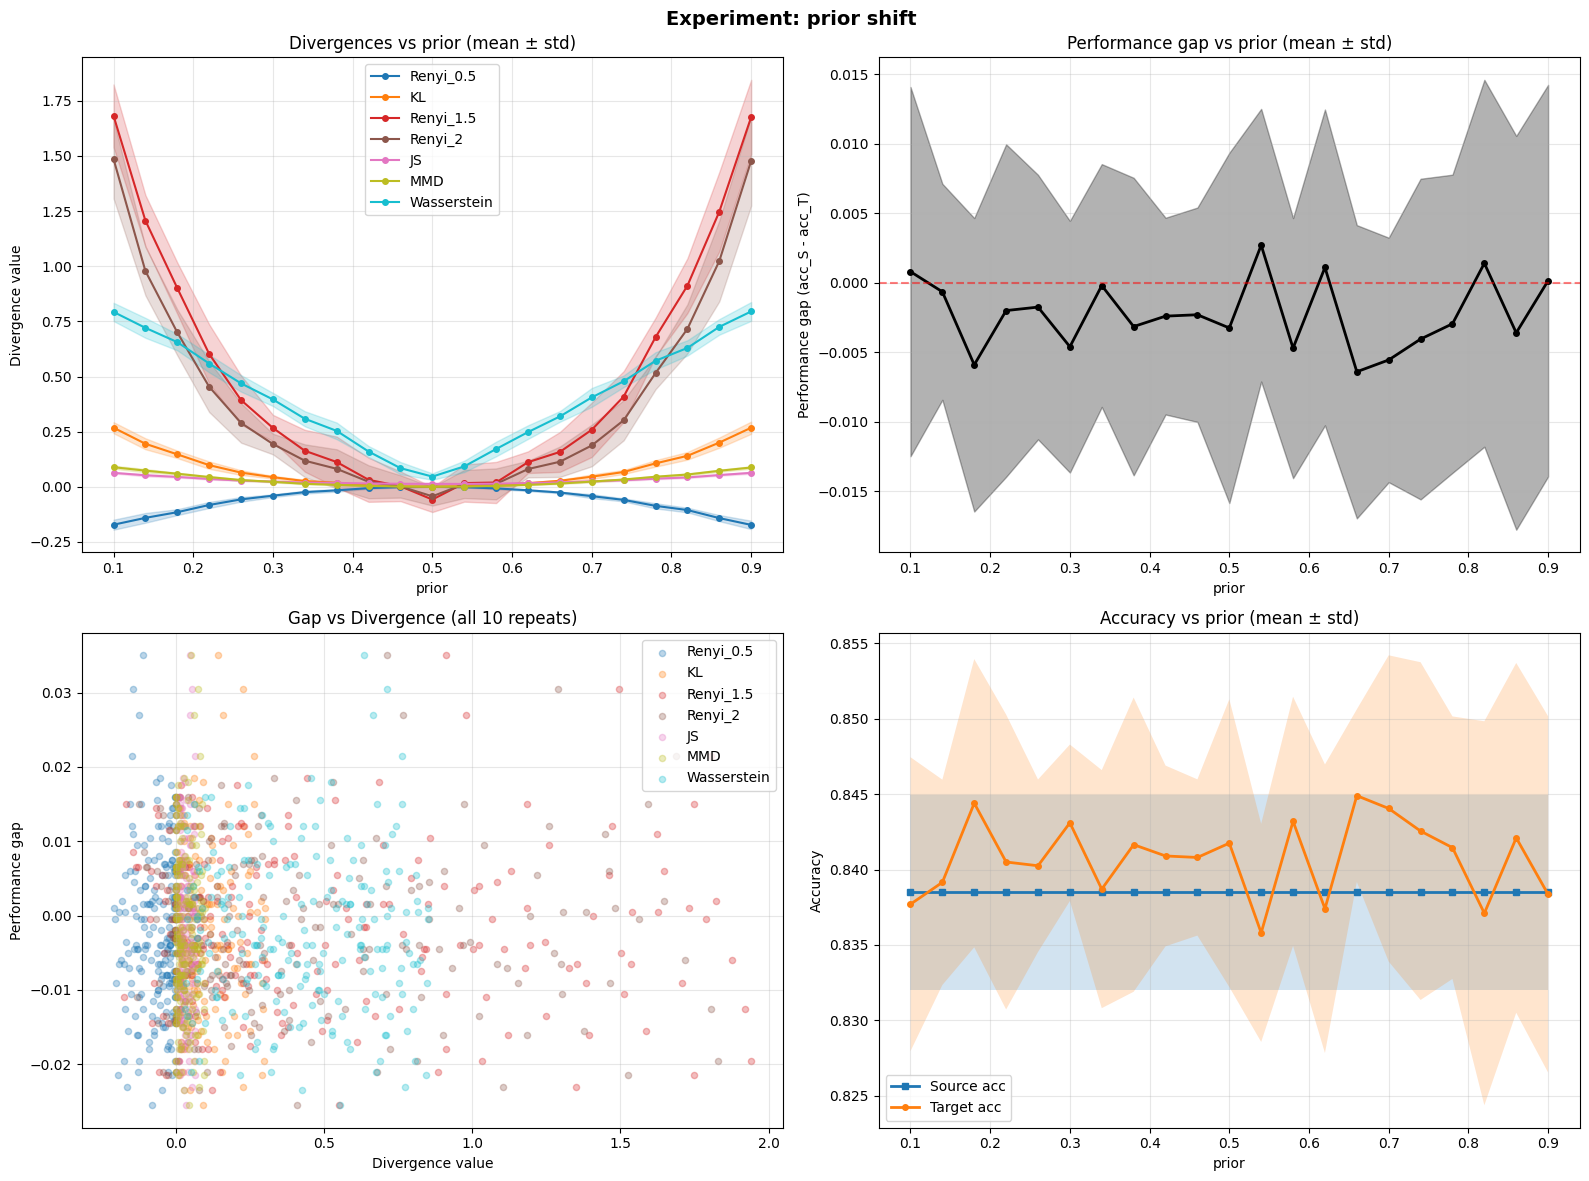


Aggregated results (first 10 rows):
           gap                  KL                  JS                 MMD  \
          mean       std      mean       std      mean       std      mean   
param                                                                        
0.10   0.00080  0.013277  0.267957  0.025092  0.063313  0.003115  0.088934   
0.14  -0.00065  0.007768  0.195067  0.024923  0.052304  0.005318  0.073289   
0.18  -0.00590  0.010551  0.147146  0.017075  0.044811  0.003140  0.059417   
0.22  -0.00200  0.011956  0.098226  0.016875  0.035504  0.002794  0.044243   
0.26  -0.00175  0.009511  0.064391  0.010735  0.028206  0.001925  0.030608   
0.30  -0.00460  0.009049  0.043571  0.006161  0.023929  0.002091  0.022589   
0.34  -0.00020  0.008731  0.026026  0.006175  0.018995  0.002647  0.013510   
0.38  -0.00315  0.010698  0.017709  0.005848  0.017384  0.003056  0.009126   
0.42  -0.00240  0.007074  0.006763  0.002800  0.015313  0.002379  0.003977   
0.46  -0.00230  0.007707  0

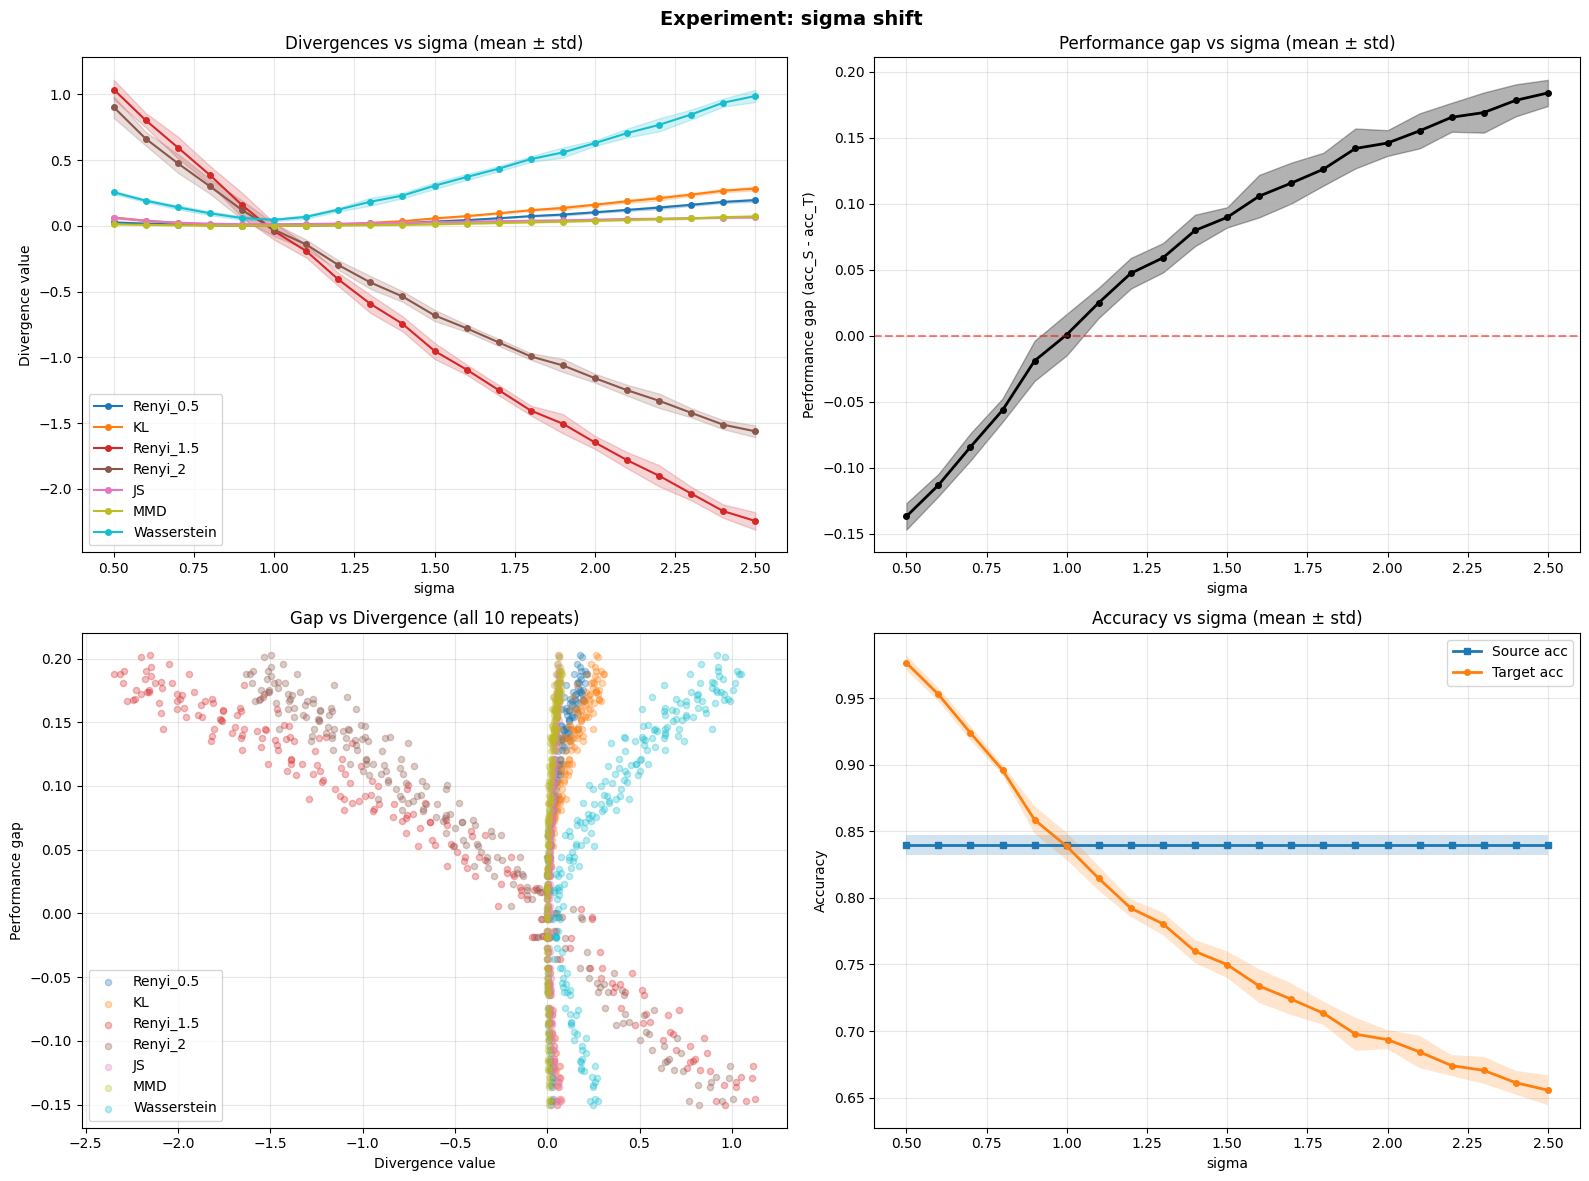


Aggregated results (first 10 rows):
           gap                  KL                  JS                 MMD  \
          mean       std      mean       std      mean       std      mean   
param                                                                        
0.5   -0.13710  0.010035  0.062488  0.008085  0.061808  0.005864  0.011501   
0.6   -0.11335  0.008466  0.038656  0.005141  0.037178  0.002758  0.006876   
0.7   -0.08440  0.010306  0.021918  0.005840  0.023746  0.002154  0.003913   
0.8   -0.05650  0.008832  0.009562  0.003485  0.016063  0.002030  0.001711   
0.9   -0.01905  0.015218  0.002153  0.001752  0.012091  0.001709  0.000678   
1.0    0.00075  0.015699  0.000520  0.000460  0.012504  0.002130  0.000325   
1.1    0.02495  0.011456  0.002596  0.001193  0.013565  0.002487  0.000718   
1.2    0.04730  0.011617  0.010602  0.002583  0.016450  0.002232  0.002466   
1.3    0.05900  0.011143  0.022460  0.005319  0.019360  0.002218  0.004998   
1.4    0.07975  0.011910  0

In [ ]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from scipy.stats import norm, entropy, wasserstein_distance
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt

np.random.seed(42)

# ======================================================
# 1. Data generation
# ======================================================
def generate_1d_data(n, mu0, mu1, sigma, prior=0.5):
    n1 = int(n * prior)
    n0 = n - n1
    X0 = np.random.normal(mu0, sigma, n0)
    X1 = np.random.normal(mu1, sigma, n1)
    X = np.concatenate([X0, X1])
    y = np.array([0]*n0 + [1]*n1)
    return X.reshape(-1,1), y

# ======================================================
# 2. Divergence functions
# ======================================================
def renyi_divergence_gaussian(mu1, sigma1, mu2, sigma2, alpha=1.5):
    """
    Calculate the Rényi divergence of order alpha between two 1D Gaussian distributions.

    Parameters:
    -----------
    mu1 : float
        Mean of the first Gaussian distribution
    sigma1 : float
        Standard deviation of the first Gaussian distribution
    sigma2 : float
        Mean of the second Gaussian distribution
    mu2 : float
        Standard deviation of the second Gaussian distribution
    alpha : float, default=1.5
        Order of the Rényi divergence (must be > 0 and != 1)

    Returns:
    --------
    float
        The Rényi divergence D_alpha(P || Q) where P ~ N(mu1, sigma1^2) and Q ~ N(mu2, sigma2^2)

    Notes:
    ------
    - For alpha = 0.5, this gives the Bhattacharyya coefficient (negated and scaled)
    - As alpha -> 1, this approaches the KL divergence
    - For alpha = 2, this is related to the chi-squared divergence
    - The function is undefined for alpha = 1 (use KL divergence instead)

    Formula:
    D_alpha(P || Q) = 1/(2(alpha-1)) * [alpha*log(sigma1^2) + (1-alpha)*log(sigma2^2)
                      - log(alpha*sigma2^2 + (1-alpha)*sigma1^2)]
                      + alpha*(mu1-mu2)^2 / [2(alpha-1)(alpha*sigma2^2 + (1-alpha)*sigma1^2)]
    """

    # Input validation
    if alpha <= 0:
        raise ValueError("Alpha must be positive")
    if abs(alpha - 1.0) < 1e-10:
        raise ValueError("Alpha cannot be 1. Use KL divergence instead.")
    if sigma1 <= 0 or sigma2 <= 0:
        raise ValueError("Standard deviations must be positive")

    # Convert to variances
    var1 = sigma1 ** 2
    var2 = sigma2 ** 2

    # Calculate combined variance term
    combined_var = alpha * var2 + (1 - alpha) * var1

    # First term: variance component
    log_term = (alpha * np.log(var1) +
                (1 - alpha) * np.log(var2) -
                np.log(combined_var))

    # Second term: mean difference component
    mean_diff_sq = (mu1 - mu2) ** 2
    mean_term = alpha * mean_diff_sq / combined_var

    # Combine terms
    renyi_div = (log_term + mean_term) / (2 * (alpha - 1))

    return renyi_div


def kl_divergence_gaussian(mu1, sigma1, mu2, sigma2):
    """
    Calculate the KL divergence between two 1D Gaussian distributions.
    This is the limit of Rényi divergence as alpha -> 1.

    Parameters:
    -----------
    mu1 : float
        Mean of the first Gaussian distribution
    sigma1 : float
        Standard deviation of the first Gaussian distribution
    mu2 : float
        Mean of the second Gaussian distribution
    sigma2 : float
        Standard deviation of the second Gaussian distribution

    Returns:
    --------
    float
        The KL divergence D_KL(P || Q)
    """
    var1 = sigma1 ** 2
    var2 = sigma2 ** 2

    kl_div = (np.log(sigma2 / sigma1) +
              (var1 + (mu1 - mu2) ** 2) / (2 * var2) - 0.5)

    return kl_div

def js_divergence_1d(x, y, bins=100):
    """Jensen-Shannon divergence via histogram approximation."""
    p_hist, edges = np.histogram(x, bins=bins, density=True)
    q_hist, _ = np.histogram(y, bins=edges, density=True)
    p_hist = p_hist / (p_hist.sum() + 1e-10)
    q_hist = q_hist / (q_hist.sum() + 1e-10)
    p_hist += 1e-10
    q_hist += 1e-10
    m = 0.5 * (p_hist + q_hist)
    return 0.5 * (entropy(p_hist, m) + entropy(q_hist, m))

def mmd_1d(x, y, sigma=1.0):
    """Maximum Mean Discrepancy with RBF kernel."""
    x = x.reshape(-1, 1)
    y = y.reshape(-1, 1)
    Kxx = np.exp(-cdist(x, x, 'sqeuclidean') / (2 * sigma**2))
    Kyy = np.exp(-cdist(y, y, 'sqeuclidean') / (2 * sigma**2))
    Kxy = np.exp(-cdist(x, y, 'sqeuclidean') / (2 * sigma**2))
    mmd = np.mean(Kxx) + np.mean(Kyy) - 2 * np.mean(Kxy)
    return float(max(0, mmd))

def compute_divergences(Z_S, Z_T):
    """Compute all divergence measures between two distributions."""
    mu_s, sigma_s = Z_S.mean(), Z_S.std()
    mu_t, sigma_t = Z_T.mean(), Z_T.std()

    return {
        "Renyi_0.5": renyi_divergence_gaussian(mu_s, sigma_s, mu_t, sigma_t, alpha=0.5),
        "KL": kl_divergence_gaussian(mu_s, sigma_s, mu_t, sigma_t),
        "Renyi_1.5": renyi_divergence_gaussian(mu_s, sigma_s, mu_t, sigma_t, alpha=1.5),
        "Renyi_2": renyi_divergence_gaussian(mu_s, sigma_s, mu_t, sigma_t, alpha=2.0),
        "JS": js_divergence_1d(Z_S, Z_T),
        "MMD": mmd_1d(Z_S, Z_T),
        "Wasserstein": wasserstein_distance(Z_S, Z_T)
    }

# ======================================================
# 3. Experiments with different parameters
# ======================================================
def run_delta_shift_experiment(n_repeats=10):
    """Vary delta (mean shift) while keeping prior and variance fixed."""
    n = 2000
    mu0, mu1, sigma = 0.0, 2.0, 1.0
    prior = 0.5

    deltas = np.linspace(-3, 3, 31)
    results = []

    for repeat in range(n_repeats):
        # Generate new source data for each repeat
        X_S, y_S = generate_1d_data(n, mu0, mu1, sigma, prior)
        clf = LogisticRegression().fit(X_S, y_S)
        acc_S = accuracy_score(y_S, clf.predict(X_S))

        for delta in deltas:
            X_T, y_T = generate_1d_data(n, mu0+delta, mu1+delta, sigma, prior)
            acc_T = accuracy_score(y_T, clf.predict(X_T))
            gap = acc_S - acc_T

            Z_S = X_S.flatten()
            Z_T = X_T.flatten()
            divs = compute_divergences(Z_S, Z_T)

            results.append({
                "repeat": repeat,
                "param": delta,
                "param_name": "delta",
                "acc_S": acc_S,
                "acc_T": acc_T,
                "gap": gap,
                **divs
            })

    return pd.DataFrame(results)

def run_prior_shift_experiment(n_repeats=10):
    """Vary target prior while keeping source prior, delta, and variance fixed."""
    n = 2000
    mu0, mu1, sigma = 0.0, 2.0, 1.0
    prior_S = 0.5

    priors_T = np.linspace(0.1, 0.9, 21)
    results = []

    for repeat in range(n_repeats):
        # Generate new source data for each repeat
        X_S, y_S = generate_1d_data(n, mu0, mu1, sigma, prior_S)
        clf = LogisticRegression().fit(X_S, y_S)
        acc_S = accuracy_score(y_S, clf.predict(X_S))

        for prior_T in priors_T:
            X_T, y_T = generate_1d_data(n, mu0, mu1, sigma, prior_T)
            acc_T = accuracy_score(y_T, clf.predict(X_T))
            gap = acc_S - acc_T

            Z_S = X_S.flatten()
            Z_T = X_T.flatten()
            divs = compute_divergences(Z_S, Z_T)

            results.append({
                "repeat": repeat,
                "param": prior_T,
                "param_name": "prior",
                "acc_S": acc_S,
                "acc_T": acc_T,
                "gap": gap,
                **divs
            })

    return pd.DataFrame(results)

def run_variance_shift_experiment(n_repeats=10):
    """Vary target variance while keeping prior, delta, and source variance fixed."""
    n = 2000
    mu0, mu1, sigma_S = 0.0, 2.0, 1.0
    prior = 0.5

    sigmas_T = np.linspace(0.5, 2.5, 21)
    results = []

    for repeat in range(n_repeats):
        # Generate new source data for each repeat
        X_S, y_S = generate_1d_data(n, mu0, mu1, sigma_S, prior)
        clf = LogisticRegression().fit(X_S, y_S)
        acc_S = accuracy_score(y_S, clf.predict(X_S))

        for sigma_T in sigmas_T:
            X_T, y_T = generate_1d_data(n, mu0, mu1, sigma_T, prior)
            acc_T = accuracy_score(y_T, clf.predict(X_T))
            gap = acc_S - acc_T

            Z_S = X_S.flatten()
            Z_T = X_T.flatten()
            divs = compute_divergences(Z_S, Z_T)

            results.append({
                "repeat": repeat,
                "param": sigma_T,
                "param_name": "sigma",
                "acc_S": acc_S,
                "acc_T": acc_T,
                "gap": gap,
                **divs
            })

    return pd.DataFrame(results)

# ======================================================
# 4. Visualization
# ======================================================
def plot_experiment_results(df, title_suffix=""):
    """Create comprehensive plots for an experiment with error bars."""
    param_name = df['param_name'].iloc[0]

    # Aggregate statistics across repeats (excluding string columns)
    numeric_cols = ['acc_S', 'acc_T', 'gap', 'Renyi_0.5', 'KL',
                    'Renyi_1.5', 'Renyi_2', 'JS', 'MMD', 'Wasserstein']
    df_agg = df.groupby('param')[numeric_cols].agg(['mean', 'std']).reset_index()

    fig, axes = plt.subplots(2, 2, figsize=(16, 12))

    div_measures = ["Renyi_0.5", "KL", "Renyi_1.5", "Renyi_2", "JS", "MMD", "Wasserstein"]
    colors = plt.cm.tab10(np.linspace(0, 1, len(div_measures)))

    param_values = df_agg['param'].values

    # Plot 1: Divergence vs parameter (with error bars)
    ax = axes[0, 0]
    for div, color in zip(div_measures, colors):
        mean_vals = df_agg[div]['mean'].values
        std_vals = df_agg[div]['std'].values
        ax.plot(param_values, mean_vals, label=div, marker='o', markersize=4, color=color)
        ax.fill_between(param_values, mean_vals - std_vals, mean_vals + std_vals,
                        alpha=0.2, color=color)
    ax.set_xlabel(f'{param_name}')
    ax.set_ylabel('Divergence value')
    ax.set_title(f'Divergences vs {param_name} (mean ± std)')
    ax.legend()
    ax.grid(True, alpha=0.3)

    # Plot 2: Performance gap vs parameter (with error bars)
    ax = axes[0, 1]
    gap_mean = df_agg['gap']['mean'].values
    gap_std = df_agg['gap']['std'].values
    ax.plot(param_values, gap_mean, marker='o', markersize=4, color='black', linewidth=2)
    ax.fill_between(param_values, gap_mean - gap_std, gap_mean + gap_std,
                    alpha=0.3, color='black')
    ax.axhline(y=0, color='r', linestyle='--', alpha=0.5)
    ax.set_xlabel(f'{param_name}')
    ax.set_ylabel('Performance gap (acc_S - acc_T)')
    ax.set_title(f'Performance gap vs {param_name} (mean ± std)')
    ax.grid(True, alpha=0.3)

    # Plot 3: Divergence vs gap (scatter with all repeats)
    ax = axes[1, 0]
    for div, color in zip(div_measures, colors):
        ax.scatter(df[div], df['gap'], label=div, alpha=0.3, s=20, color=color)
    ax.set_xlabel('Divergence value')
    ax.set_ylabel('Performance gap')
    ax.set_title(f'Gap vs Divergence (all {df["repeat"].max()+1} repeats)')
    ax.legend()
    ax.grid(True, alpha=0.3)

    # Plot 4: Source vs Target accuracy (with error bars)
    ax = axes[1, 1]
    acc_s_mean = df_agg['acc_S']['mean'].values
    acc_s_std = df_agg['acc_S']['std'].values
    acc_t_mean = df_agg['acc_T']['mean'].values
    acc_t_std = df_agg['acc_T']['std'].values

    ax.plot(param_values, acc_s_mean, label='Source acc', marker='s', markersize=4, linewidth=2)
    ax.fill_between(param_values, acc_s_mean - acc_s_std, acc_s_mean + acc_s_std, alpha=0.2)
    ax.plot(param_values, acc_t_mean, label='Target acc', marker='o', markersize=4, linewidth=2)
    ax.fill_between(param_values, acc_t_mean - acc_t_std, acc_t_mean + acc_t_std, alpha=0.2)
    ax.set_xlabel(f'{param_name}')
    ax.set_ylabel('Accuracy')
    ax.set_title(f'Accuracy vs {param_name} (mean ± std)')
    ax.legend()
    ax.grid(True, alpha=0.3)

    plt.suptitle(f'Experiment: {param_name} shift {title_suffix}', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

# ======================================================
# 5. Run all experiments
# ======================================================
n_repeats = 10  # Number of repeated measurements

print("="*80)
print(f"EXPERIMENT 1: Delta (Mean) Shift ({n_repeats} repeats)")
print("="*80)
df_delta = run_delta_shift_experiment(n_repeats=n_repeats)
plot_experiment_results(df_delta)
# Show aggregated statistics
df_delta_agg = df_delta.groupby('param')[['gap', 'KL', 'JS', 'MMD', 'Wasserstein']].agg(['mean', 'std'])
print("\nAggregated results (first 10 rows):")
print(df_delta_agg.head(10))

print("\n" + "="*80)
print(f"EXPERIMENT 2: Prior Probability Shift ({n_repeats} repeats)")
print("="*80)
df_prior = run_prior_shift_experiment(n_repeats=n_repeats)
plot_experiment_results(df_prior)
df_prior_agg = df_prior.groupby('param')[['gap', 'KL', 'JS', 'MMD', 'Wasserstein']].agg(['mean', 'std'])
print("\nAggregated results (first 10 rows):")
print(df_prior_agg.head(10))

print("\n" + "="*80)
print(f"EXPERIMENT 3: Variance Shift ({n_repeats} repeats)")
print("="*80)
df_variance = run_variance_shift_experiment(n_repeats=n_repeats)
plot_experiment_results(df_variance)
df_variance_agg = df_variance.groupby('param')[['gap', 'KL', 'JS', 'MMD', 'Wasserstein']].agg(['mean', 'std'])
print("\nAggregated results (first 10 rows):")
print(df_variance_agg.head(10))

# Summary comparison
print("\n" + "="*80)
print("SUMMARY: Correlation between divergences and performance gap")
print("="*80)
div_measures = ["Renyi_0.5", "KL", "Renyi_1.5", "Renyi_2", "JS", "MMD", "Wasserstein"]
for exp_name, df in [("Delta shift", df_delta), ("Prior shift", df_prior), ("Variance shift", df_variance)]:
    print(f"\n{exp_name}:")
    for div in div_measures:
        corr = df[div].corr(df['gap'].abs())
        print(f"  {div:18s}: {corr:.4f}")

## 1-D classifcation - both feature and label divergences

EXPERIMENT 1: Delta (Mean) Shift (10 repeats)


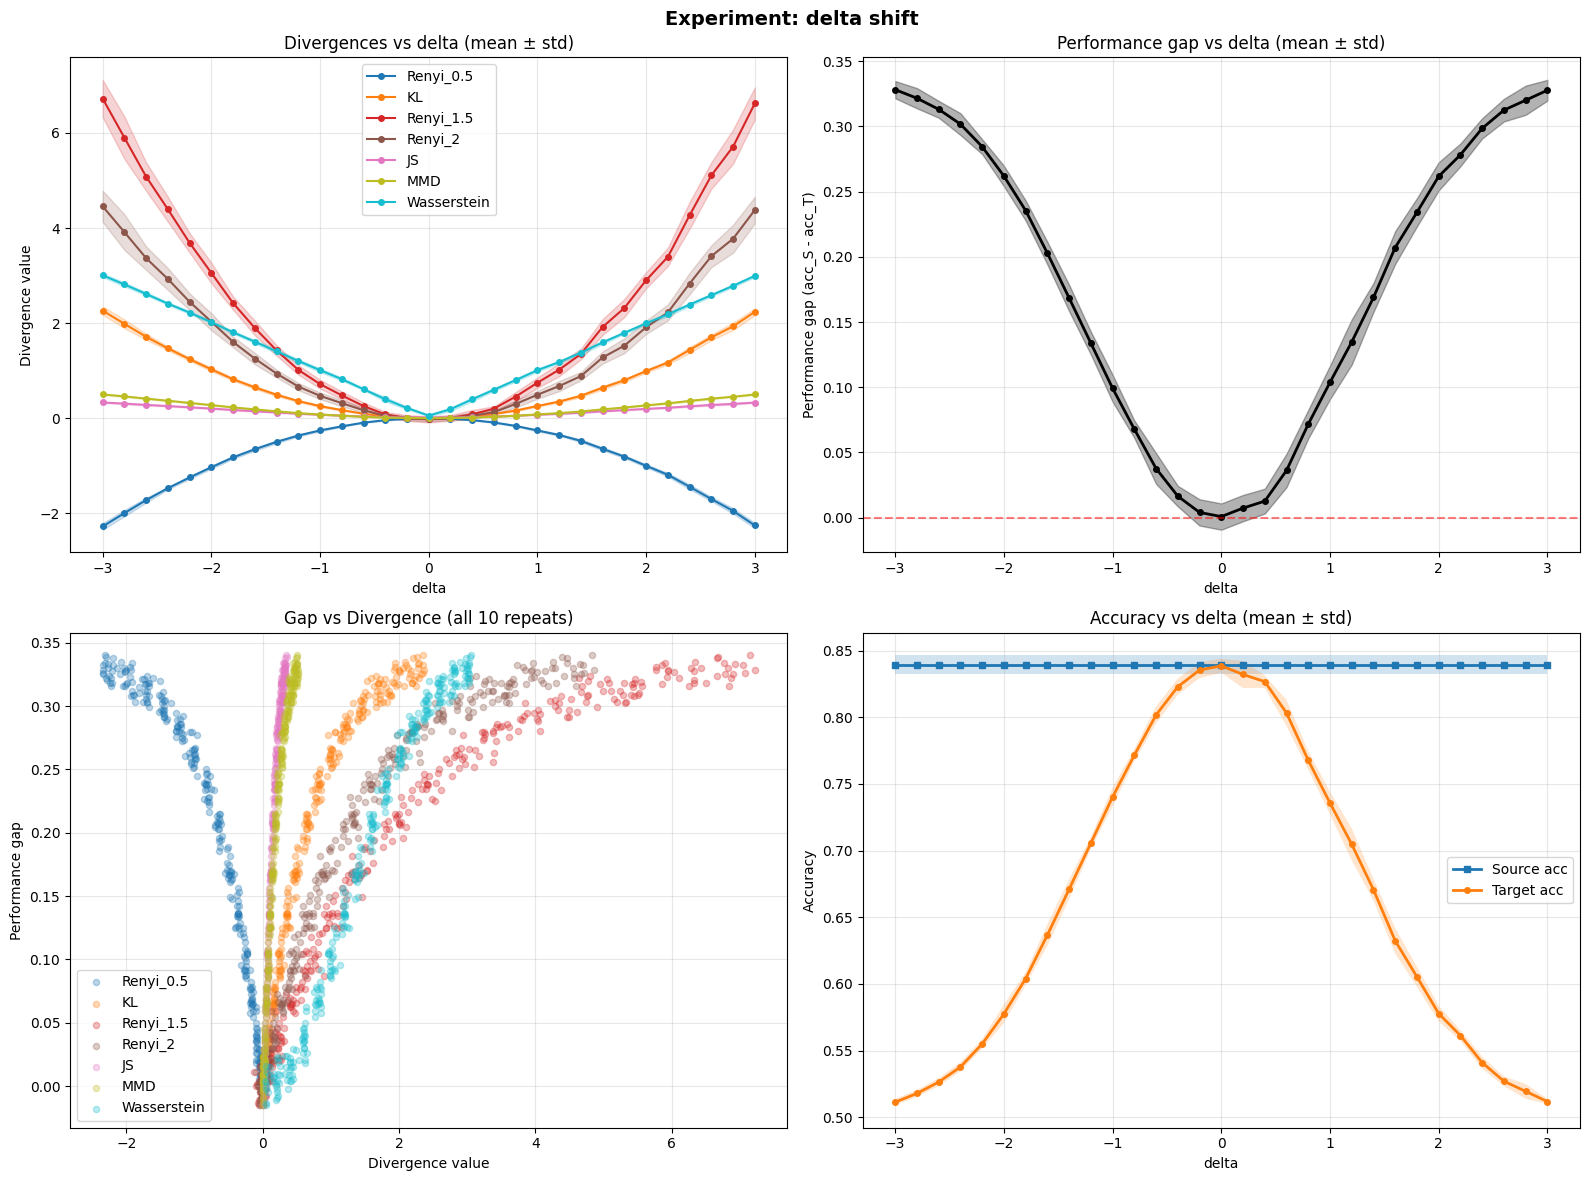


Aggregated results (first 10 rows):
           gap                  KL                  JS                 MMD  \
          mean       std      mean       std      mean       std      mean   
param                                                                        
-3.0   0.32810  0.006595  2.263120  0.085725  0.331059  0.010989  0.500522   
-2.8   0.32155  0.007758  1.985545  0.091843  0.306629  0.015071  0.458499   
-2.6   0.31305  0.006470  1.712794  0.064055  0.279471  0.014315  0.412576   
-2.4   0.30170  0.008374  1.469469  0.041656  0.255599  0.011513  0.367132   
-2.2   0.28440  0.005685  1.241161  0.038239  0.228992  0.010997  0.321856   
-2.0   0.26190  0.007884  1.027458  0.040794  0.203154  0.012083  0.275467   
-1.8   0.23545  0.007722  0.819620  0.030207  0.172944  0.010238  0.227018   
-1.6   0.20275  0.008709  0.648019  0.032810  0.146359  0.008732  0.185618   
-1.4   0.16840  0.010102  0.493166  0.029431  0.120136  0.007454  0.144948   
-1.2   0.13380  0.008772  0

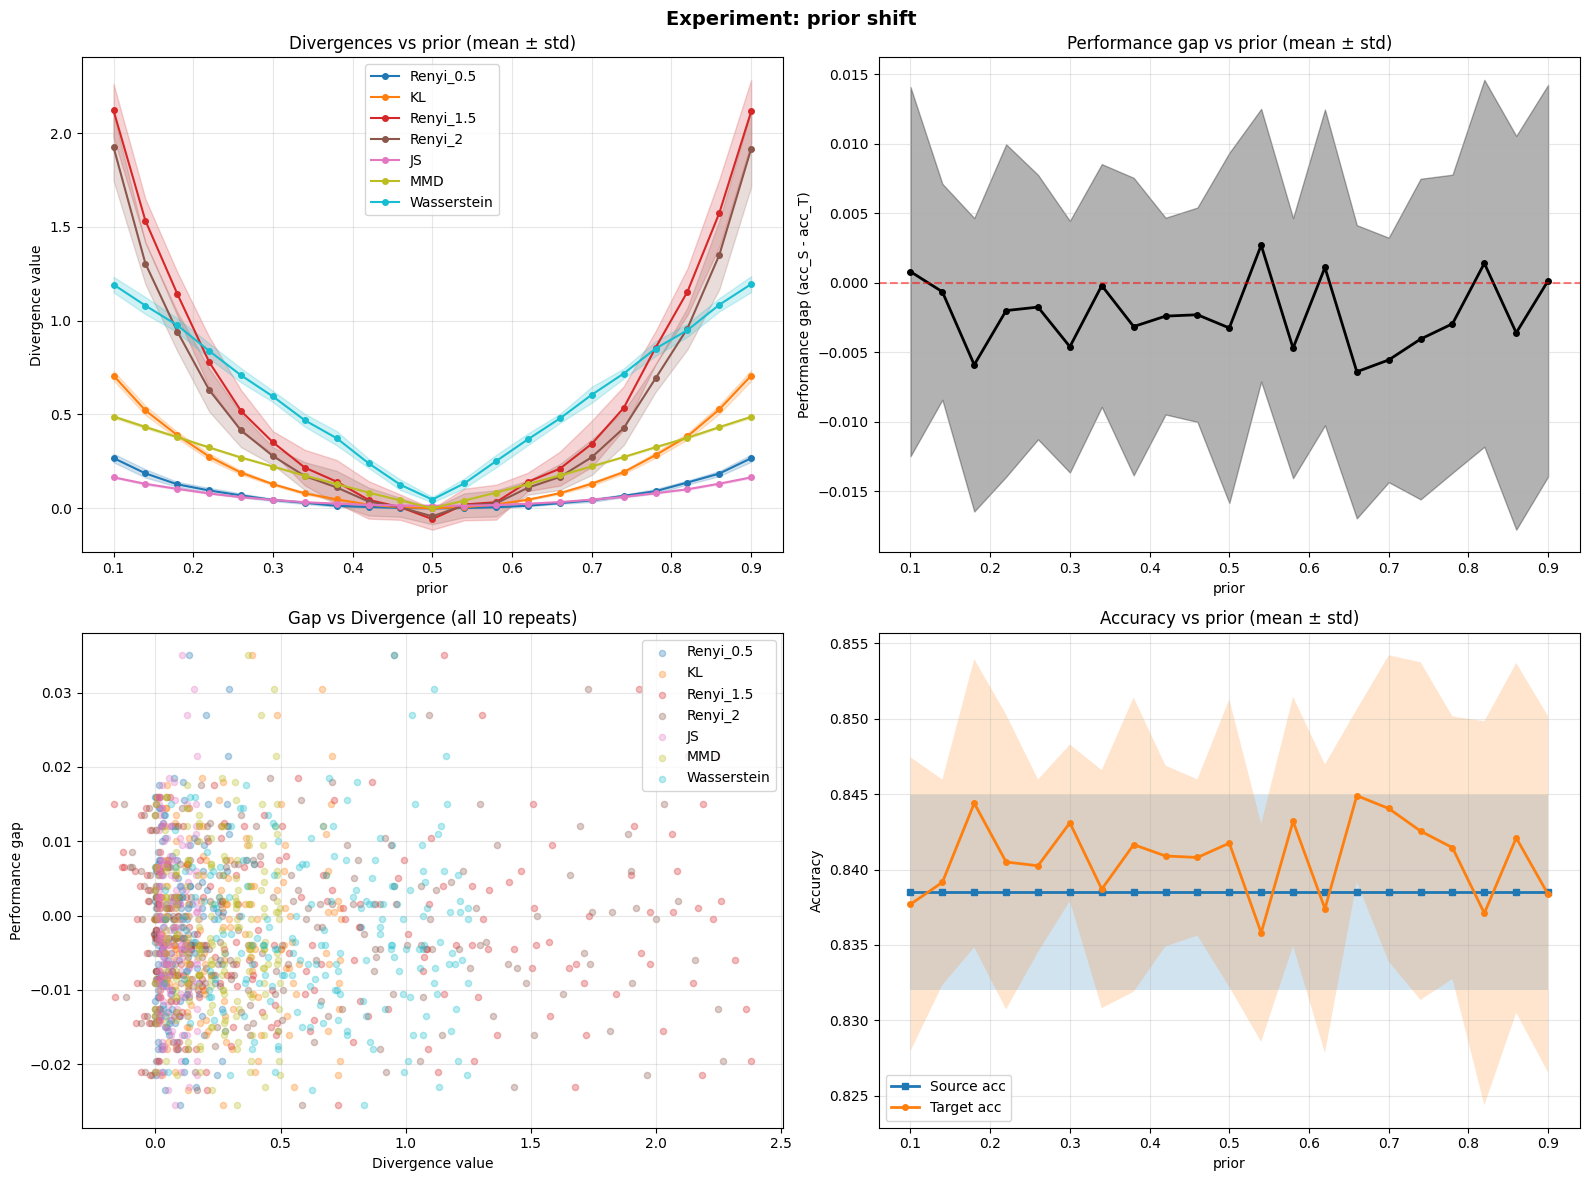


Aggregated results (first 10 rows):
           gap                  KL                  JS                 MMD  \
          mean       std      mean       std      mean       std      mean   
param                                                                        
0.10   0.00080  0.013277  0.707402  0.025092  0.165062  0.003115  0.488934   
0.14  -0.00065  0.007768  0.521819  0.024923  0.130118  0.005318  0.433289   
0.18  -0.00590  0.010551  0.389761  0.017075  0.103576  0.003140  0.379417   
0.22  -0.00200  0.011956  0.275420  0.016875  0.078895  0.002794  0.324243   
0.26  -0.00175  0.009511  0.189907  0.010735  0.059168  0.001925  0.270608   
0.30  -0.00460  0.009049  0.128301  0.006161  0.044935  0.002091  0.222589   
0.34  -0.00020  0.008731  0.079434  0.006175  0.032281  0.002647  0.174010   
0.38  -0.00315  0.010698  0.047082  0.005848  0.024709  0.003056  0.129126   
0.42  -0.00240  0.007074  0.019674  0.002800  0.018538  0.002379  0.083977   
0.46  -0.00230  0.007707  0

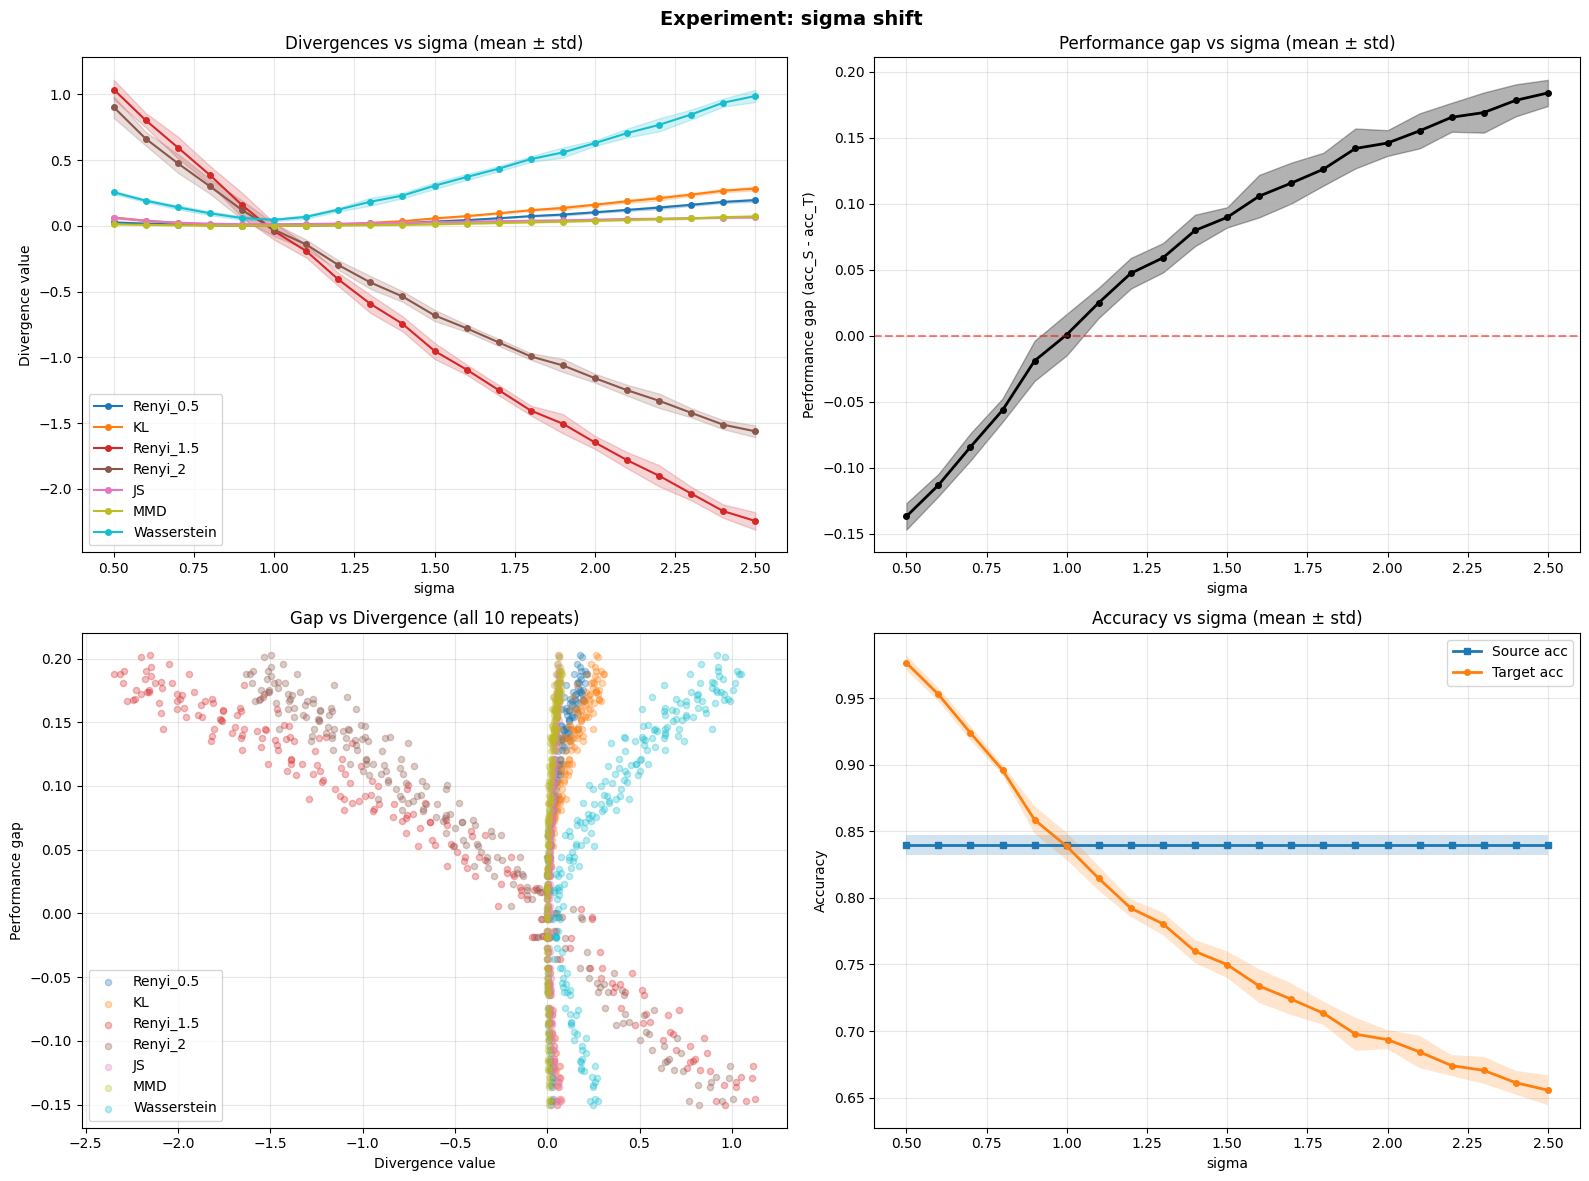


Aggregated results (first 10 rows):
           gap                  KL                  JS                 MMD  \
          mean       std      mean       std      mean       std      mean   
param                                                                        
0.5   -0.13710  0.010035  0.062488  0.008085  0.061808  0.005864  0.011501   
0.6   -0.11335  0.008466  0.038656  0.005141  0.037178  0.002758  0.006876   
0.7   -0.08440  0.010306  0.021918  0.005840  0.023746  0.002154  0.003913   
0.8   -0.05650  0.008832  0.009562  0.003485  0.016063  0.002030  0.001711   
0.9   -0.01905  0.015218  0.002153  0.001752  0.012091  0.001709  0.000678   
1.0    0.00075  0.015699  0.000520  0.000460  0.012504  0.002130  0.000325   
1.1    0.02495  0.011456  0.002596  0.001193  0.013565  0.002487  0.000718   
1.2    0.04730  0.011617  0.010602  0.002583  0.016450  0.002232  0.002466   
1.3    0.05900  0.011143  0.022460  0.005319  0.019360  0.002218  0.004998   
1.4    0.07975  0.011910  0

In [ ]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from scipy.stats import norm, entropy, wasserstein_distance
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt

np.random.seed(42)

# ======================================================
# 1. Data generation
# ======================================================
def generate_1d_data(n, mu0, mu1, sigma, prior=0.5):
    n1 = int(n * prior)
    n0 = n - n1
    X0 = np.random.normal(mu0, sigma, n0)
    X1 = np.random.normal(mu1, sigma, n1)
    X = np.concatenate([X0, X1])
    y = np.array([0]*n0 + [1]*n1)
    return X.reshape(-1,1), y

# ======================================================
# 2. Divergence functions
# ======================================================
def renyi_divergence_gaussian(mu1, sigma1, mu2, sigma2, alpha=1.5):
    """Rényi divergence between two 1D Gaussian distributions."""
    if sigma1 <= 0 or sigma2 <= 0:
        raise ValueError("Standard deviations must be positive.")
    if alpha <= 0:
        raise ValueError("Alpha must be positive.")

    if np.isclose(alpha, 1.0):
        # KL divergence (limit case)
        return np.log(sigma2 / sigma1) + (sigma1**2 + (mu1 - mu2)**2) / (2 * sigma2**2) - 0.5

    var1 = sigma1 ** 2
    var2 = sigma2 ** 2

    # Calculate combined variance term
    combined_var = alpha * var2 + (1 - alpha) * var1

    # First term: variance component
    log_term = (alpha * np.log(var1) +
                (1 - alpha) * np.log(var2) -
                np.log(combined_var))

    # Second term: mean difference component
    mean_diff_sq = (mu1 - mu2) ** 2
    mean_term = alpha * mean_diff_sq / combined_var

    # Combine terms
    renyi_div = (log_term + mean_term) / (2 * (alpha - 1))

    return renyi_div

def js_divergence(x, y, bins=100):
    """Jensen-Shannon divergence via histogram approximation."""
    p_hist, edges = np.histogram(x, bins=bins, density=True)
    q_hist, _ = np.histogram(y, bins=edges, density=True)
    p_hist = p_hist / (p_hist.sum() + 1e-10)
    q_hist = q_hist / (q_hist.sum() + 1e-10)
    p_hist += 1e-10
    q_hist += 1e-10
    m = 0.5 * (p_hist + q_hist)
    return 0.5 * (entropy(p_hist, m) + entropy(q_hist, m))

def mmd(x, y, sigma=1.0):
    """Maximum Mean Discrepancy with RBF kernel."""
    x = x.reshape(-1, 1)
    y = y.reshape(-1, 1)
    Kxx = np.exp(-cdist(x, x, 'sqeuclidean') / (2 * sigma**2))
    Kyy = np.exp(-cdist(y, y, 'sqeuclidean') / (2 * sigma**2))
    Kxy = np.exp(-cdist(x, y, 'sqeuclidean') / (2 * sigma**2))
    mmd = np.mean(Kxx) + np.mean(Kyy) - 2 * np.mean(Kxy)
    return float(max(0, mmd))


def compute_divergences(X_S, y_S, X_T, y_T):
    """Compute all divergence measures between two distributions.
    Combines both feature divergences and label divergences."""
    # Feature divergences
    Z_S = X_S.flatten()
    Z_T = X_T.flatten()
    mu_s, sigma_s = Z_S.mean(), Z_S.std()
    mu_t, sigma_t = Z_T.mean(), Z_T.std()

    feat_renyi_0_5 = renyi_divergence_gaussian(mu_s, sigma_s, mu_t, sigma_t, alpha=0.5)
    feat_renyi_1 = renyi_divergence_gaussian(mu_s, sigma_s, mu_t, sigma_t, alpha=1.0)
    feat_renyi_1_5 = renyi_divergence_gaussian(mu_s, sigma_s, mu_t, sigma_t, alpha=1.5)
    feat_renyi_2 = renyi_divergence_gaussian(mu_s, sigma_s, mu_t, sigma_t, alpha=2.0)
    feat_js = js_divergence(Z_S, Z_T)
    feat_mmd = mmd(Z_S, Z_T)
    feat_wass = wasserstein_distance(Z_S, Z_T)


    return {
        # Combined: feature + label (weighted equally)
        "Renyi_0.5": feat_renyi_0_5,
        "KL": feat_renyi_1,
        "Renyi_1.5": feat_renyi_1_5,
        "Renyi_2": feat_renyi_2,
        "JS": feat_js,
        "MMD": feat_mmd,
        "Wasserstein": feat_wass,

    }

# ======================================================
# 3. Experiments with different parameters
# ======================================================
def run_delta_shift_experiment(n_repeats=10):
    """Vary delta (mean shift) while keeping prior and variance fixed."""
    n = 2000
    mu0, mu1, sigma = 0.0, 2.0, 1.0
    prior = 0.5

    deltas = np.linspace(-3, 3, 31)
    results = []

    for repeat in range(n_repeats):
        # Generate new source data for each repeat
        X_S, y_S = generate_1d_data(n, mu0, mu1, sigma, prior)
        clf = LogisticRegression().fit(X_S, y_S)
        acc_S = accuracy_score(y_S, clf.predict(X_S))

        for delta in deltas:
            X_T, y_T = generate_1d_data(n, mu0+delta, mu1+delta, sigma, prior)
            acc_T = accuracy_score(y_T, clf.predict(X_T))
            gap = acc_S - acc_T

            divs = compute_divergences(X_S, y_S, X_T, y_T)

            results.append({
                "repeat": repeat,
                "param": delta,
                "param_name": "delta",
                "acc_S": acc_S,
                "acc_T": acc_T,
                "gap": gap,
                **divs
            })

    return pd.DataFrame(results)

def run_prior_shift_experiment(n_repeats=10):
    """Vary target prior while keeping source prior, delta, and variance fixed."""
    n = 2000
    mu0, mu1, sigma = 0.0, 2.0, 1.0
    prior_S = 0.5

    priors_T = np.linspace(0.1, 0.9, 21)
    results = []

    for repeat in range(n_repeats):
        # Generate new source data for each repeat
        X_S, y_S = generate_1d_data(n, mu0, mu1, sigma, prior_S)
        clf = LogisticRegression().fit(X_S, y_S)
        acc_S = accuracy_score(y_S, clf.predict(X_S))

        for prior_T in priors_T:
            X_T, y_T = generate_1d_data(n, mu0, mu1, sigma, prior_T)
            acc_T = accuracy_score(y_T, clf.predict(X_T))
            gap = acc_S - acc_T

            divs = compute_divergences(X_S, y_S, X_T, y_T)

            results.append({
                "repeat": repeat,
                "param": prior_T,
                "param_name": "prior",
                "acc_S": acc_S,
                "acc_T": acc_T,
                "gap": gap,
                **divs
            })

    return pd.DataFrame(results)

def run_variance_shift_experiment(n_repeats=10):
    """Vary target variance while keeping prior, delta, and source variance fixed."""
    n = 2000
    mu0, mu1, sigma_S = 0.0, 2.0, 1.0
    prior = 0.5

    sigmas_T = np.linspace(0.5, 2.5, 21)
    results = []

    for repeat in range(n_repeats):
        # Generate new source data for each repeat
        X_S, y_S = generate_1d_data(n, mu0, mu1, sigma_S, prior)
        clf = LogisticRegression().fit(X_S, y_S)
        acc_S = accuracy_score(y_S, clf.predict(X_S))

        for sigma_T in sigmas_T:
            X_T, y_T = generate_1d_data(n, mu0, mu1, sigma_T, prior)
            acc_T = accuracy_score(y_T, clf.predict(X_T))
            gap = acc_S - acc_T

            divs = compute_divergences(X_S, y_S, X_T, y_T)

            results.append({
                "repeat": repeat,
                "param": sigma_T,
                "param_name": "sigma",
                "acc_S": acc_S,
                "acc_T": acc_T,
                "gap": gap,
                **divs
            })

    return pd.DataFrame(results)

# ======================================================
# 4. Visualization
# ======================================================
def plot_experiment_results(df, title_suffix=""):
    """Create comprehensive plots for an experiment with error bars."""
    param_name = df['param_name'].iloc[0]

    # Aggregate statistics across repeats (excluding string columns)
    numeric_cols = ['acc_S', 'acc_T', 'gap', 'Renyi_0.5', 'KL',
                    'Renyi_1.5', 'Renyi_2', 'JS', 'MMD', 'Wasserstein',
                    'Feat_Renyi_1', 'Label_KL', 'Feat_JS', 'Label_JS',
                    'Feat_Wass', 'Label_TV']
    df_agg = df.groupby('param')[numeric_cols].agg(['mean', 'std']).reset_index()

    fig, axes = plt.subplots(2, 2, figsize=(16, 12))

    div_measures = ["Renyi_0.5", "KL", "Renyi_1.5", "Renyi_2", "JS", "MMD", "Wasserstein"]
    colors = plt.cm.tab10(np.linspace(0, 1, len(div_measures)))

    param_values = df_agg['param'].values

    # Plot 1: Divergence vs parameter (with error bars)
    ax = axes[0, 0]
    for div, color in zip(div_measures, colors):
        mean_vals = df_agg[div]['mean'].values
        std_vals = df_agg[div]['std'].values
        ax.plot(param_values, mean_vals, label=div, marker='o', markersize=4, color=color)
        ax.fill_between(param_values, mean_vals - std_vals, mean_vals + std_vals,
                        alpha=0.2, color=color)
    ax.set_xlabel(f'{param_name}')
    ax.set_ylabel('Divergence value')
    ax.set_title(f'Divergences vs {param_name} (mean ± std)')
    ax.legend()
    ax.grid(True, alpha=0.3)

    # Plot 2: Performance gap vs parameter (with error bars)
    ax = axes[0, 1]
    gap_mean = df_agg['gap']['mean'].values
    gap_std = df_agg['gap']['std'].values
    ax.plot(param_values, gap_mean, marker='o', markersize=4, color='black', linewidth=2)
    ax.fill_between(param_values, gap_mean - gap_std, gap_mean + gap_std,
                    alpha=0.3, color='black')
    ax.axhline(y=0, color='r', linestyle='--', alpha=0.5)
    ax.set_xlabel(f'{param_name}')
    ax.set_ylabel('Performance gap (acc_S - acc_T)')
    ax.set_title(f'Performance gap vs {param_name} (mean ± std)')
    ax.grid(True, alpha=0.3)

    # Plot 3: Divergence vs gap (scatter with all repeats)
    ax = axes[1, 0]
    for div, color in zip(div_measures, colors):
        ax.scatter(df[div], df['gap'], label=div, alpha=0.3, s=20, color=color)
    ax.set_xlabel('Divergence value')
    ax.set_ylabel('Performance gap')
    ax.set_title(f'Gap vs Divergence (all {df["repeat"].max()+1} repeats)')
    ax.legend()
    ax.grid(True, alpha=0.3)

    # Plot 4: Source vs Target accuracy (with error bars)
    ax = axes[1, 1]
    acc_s_mean = df_agg['acc_S']['mean'].values
    acc_s_std = df_agg['acc_S']['std'].values
    acc_t_mean = df_agg['acc_T']['mean'].values
    acc_t_std = df_agg['acc_T']['std'].values

    ax.plot(param_values, acc_s_mean, label='Source acc', marker='s', markersize=4, linewidth=2)
    ax.fill_between(param_values, acc_s_mean - acc_s_std, acc_s_mean + acc_s_std, alpha=0.2)
    ax.plot(param_values, acc_t_mean, label='Target acc', marker='o', markersize=4, linewidth=2)
    ax.fill_between(param_values, acc_t_mean - acc_t_std, acc_t_mean + acc_t_std, alpha=0.2)
    ax.set_xlabel(f'{param_name}')
    ax.set_ylabel('Accuracy')
    ax.set_title(f'Accuracy vs {param_name} (mean ± std)')
    ax.legend()
    ax.grid(True, alpha=0.3)

    plt.suptitle(f'Experiment: {param_name} shift {title_suffix}', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

# ======================================================
# 5. Run all experiments
# ======================================================
n_repeats = 10  # Number of repeated measurements

print("="*80)
print(f"EXPERIMENT 1: Delta (Mean) Shift ({n_repeats} repeats)")
print("="*80)
df_delta = run_delta_shift_experiment(n_repeats=n_repeats)
plot_experiment_results(df_delta)
# Show aggregated statistics
df_delta_agg = df_delta.groupby('param')[['gap', 'KL', 'JS', 'MMD', 'Wasserstein']].agg(['mean', 'std'])
print("\nAggregated results (first 10 rows):")
print(df_delta_agg.head(10))

print("\n" + "="*80)
print(f"EXPERIMENT 2: Prior Probability Shift ({n_repeats} repeats)")
print("="*80)
df_prior = run_prior_shift_experiment(n_repeats=n_repeats)
plot_experiment_results(df_prior)
df_prior_agg = df_prior.groupby('param')[['gap', 'KL', 'JS', 'MMD', 'Wasserstein']].agg(['mean', 'std'])
print("\nAggregated results (first 10 rows):")
print(df_prior_agg.head(10))

print("\n" + "="*80)
print(f"EXPERIMENT 3: Variance Shift ({n_repeats} repeats)")
print("="*80)
df_variance = run_variance_shift_experiment(n_repeats=n_repeats)
plot_experiment_results(df_variance)
df_variance_agg = df_variance.groupby('param')[['gap', 'KL', 'JS', 'MMD', 'Wasserstein']].agg(['mean', 'std'])
print("\nAggregated results (first 10 rows):")
print(df_variance_agg.head(10))

# Summary comparison
print("\n" + "="*80)
print("SUMMARY: Correlation between divergences and performance gap")
print("="*80)
div_measures = ["Renyi_0.5", "KL", "Renyi_1.5", "Renyi_2", "JS", "MMD", "Wasserstein"]
for exp_name, df in [("Delta shift", df_delta), ("Prior shift", df_prior), ("Variance shift", df_variance)]:
    print(f"\n{exp_name}:")
    for div in div_measures:
        corr = df[div].corr(df['gap'].abs())
        print(f"  {div:18s}: {corr:.4f}")

## Simple Regression


REGRESSION EXPERIMENTS - 2D DIVERGENCE ANALYSIS

EXPERIMENT 1: X Shift (Covariate Shift) - 10 repeats


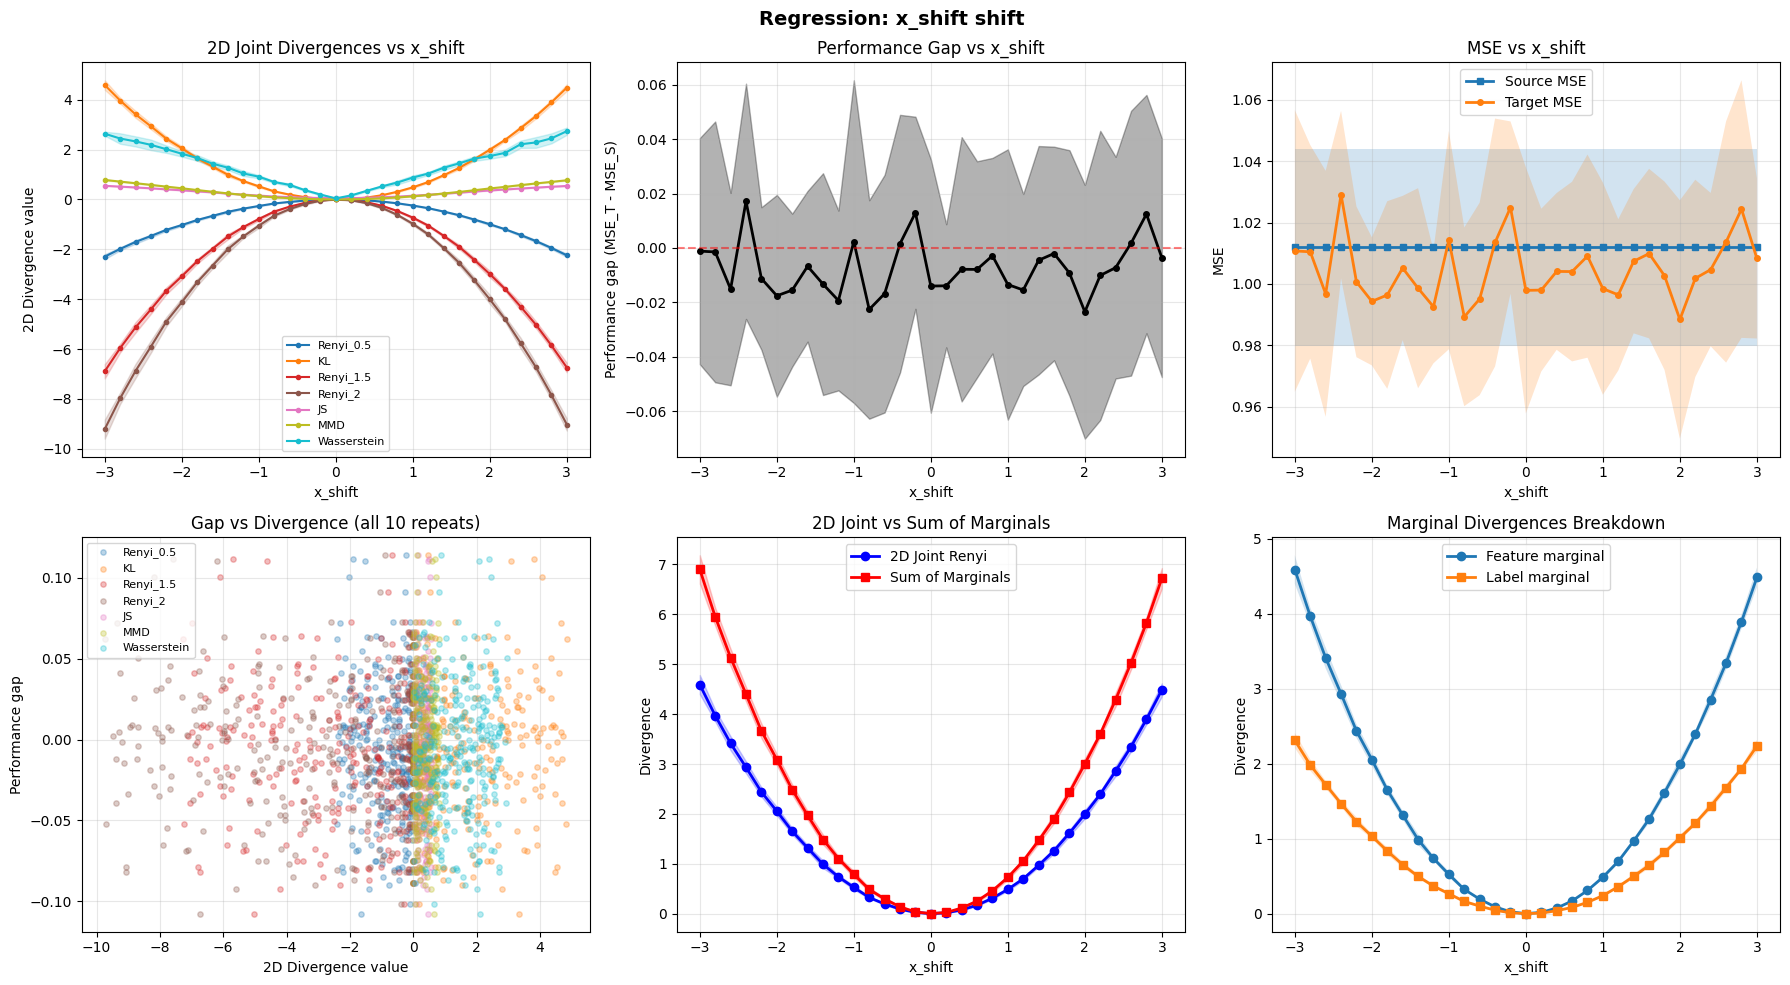


Sample results:
            gap        KL  Marginal_Sum
param                                  
-3.0  -0.001192  4.591907      6.900981
-2.8  -0.001473  3.971281      5.953370
-2.6  -0.015146  3.414527      5.134296
-2.4   0.017133  2.934121      4.401405
-2.2  -0.011259  2.439140      3.664741
-2.0  -0.017604  2.056194      3.088135
-1.8  -0.015529  1.652543      2.487362
-1.6  -0.006755  1.318416      1.970871
-1.4  -0.013320  0.990418      1.486746
-1.2  -0.019348  0.738879      1.105760

EXPERIMENT 2: Noise Shift - 10 repeats


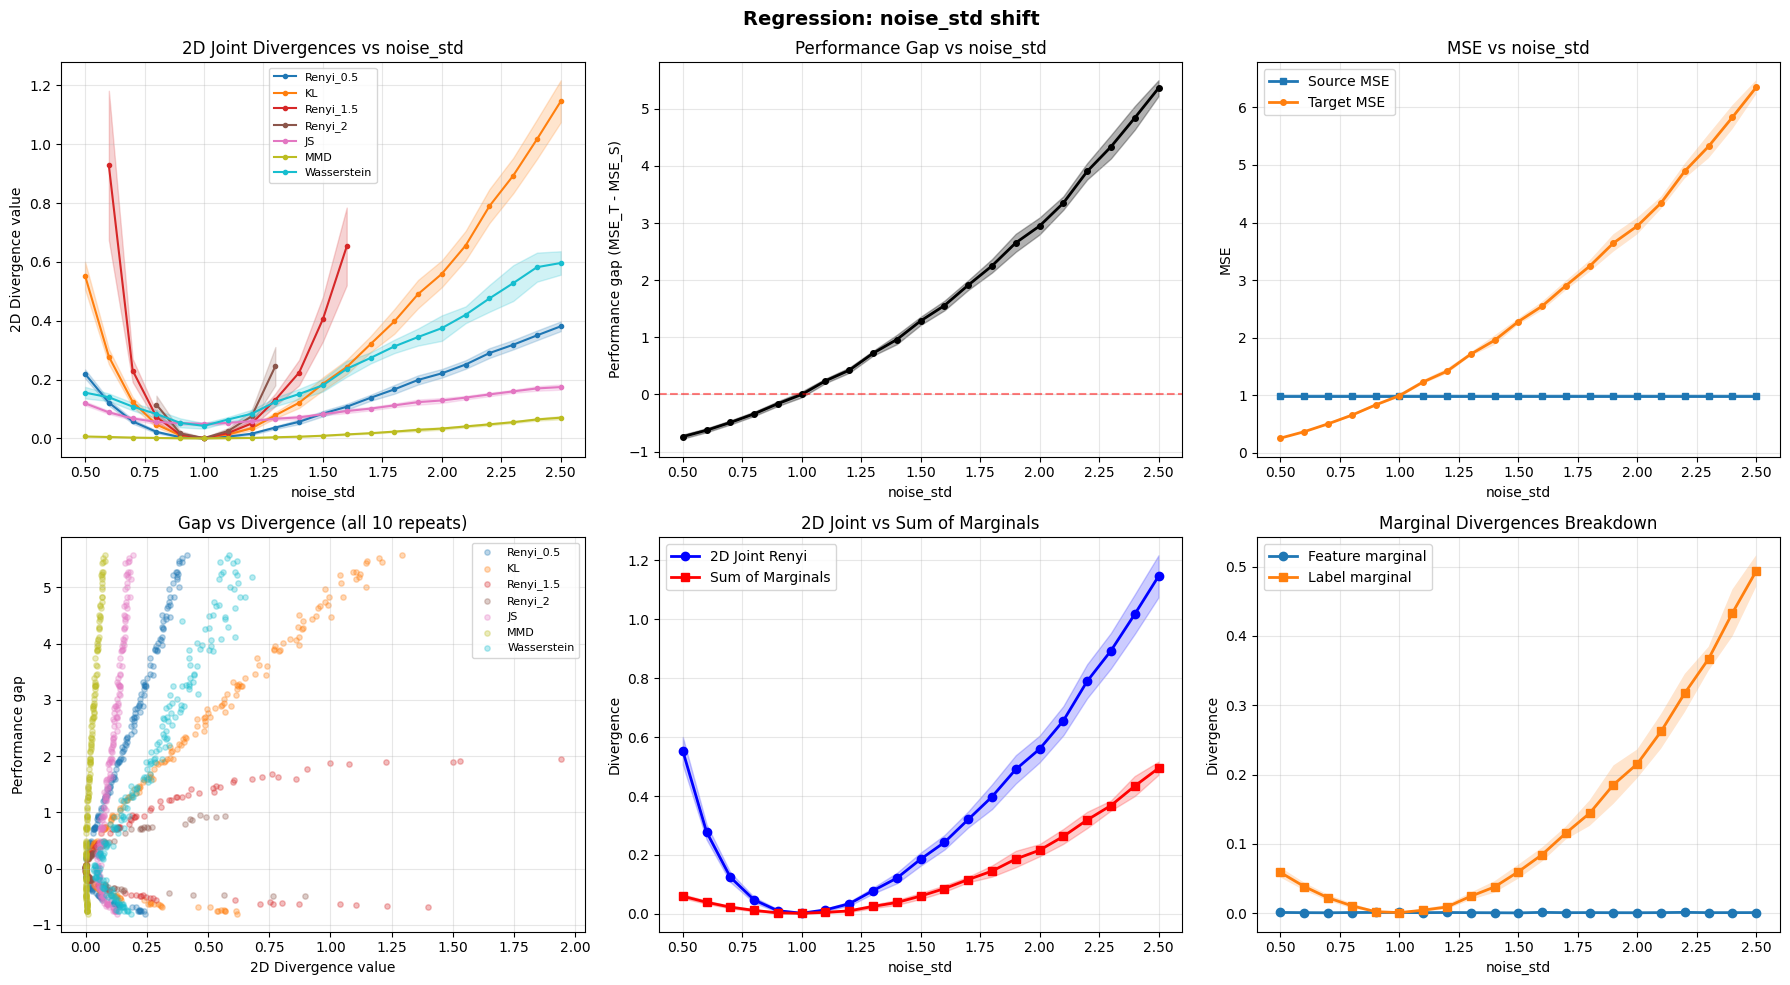


Sample results:
            gap        KL  Marginal_Sum
param                                  
0.5   -0.738302  0.553427      0.059696
0.6   -0.626807  0.278071      0.039191
0.7   -0.490415  0.124211      0.022752
0.8   -0.339599  0.047141      0.011584
0.9   -0.161158  0.010441      0.003218
1.0   -0.000197  0.002045      0.001766
1.1    0.238411  0.013368      0.005052
1.2    0.424759  0.034100      0.009943
1.3    0.721109  0.078594      0.025165
1.4    0.961797  0.121233      0.038443

EXPERIMENT 3: Slope Shift (Concept Drift) - 10 repeats


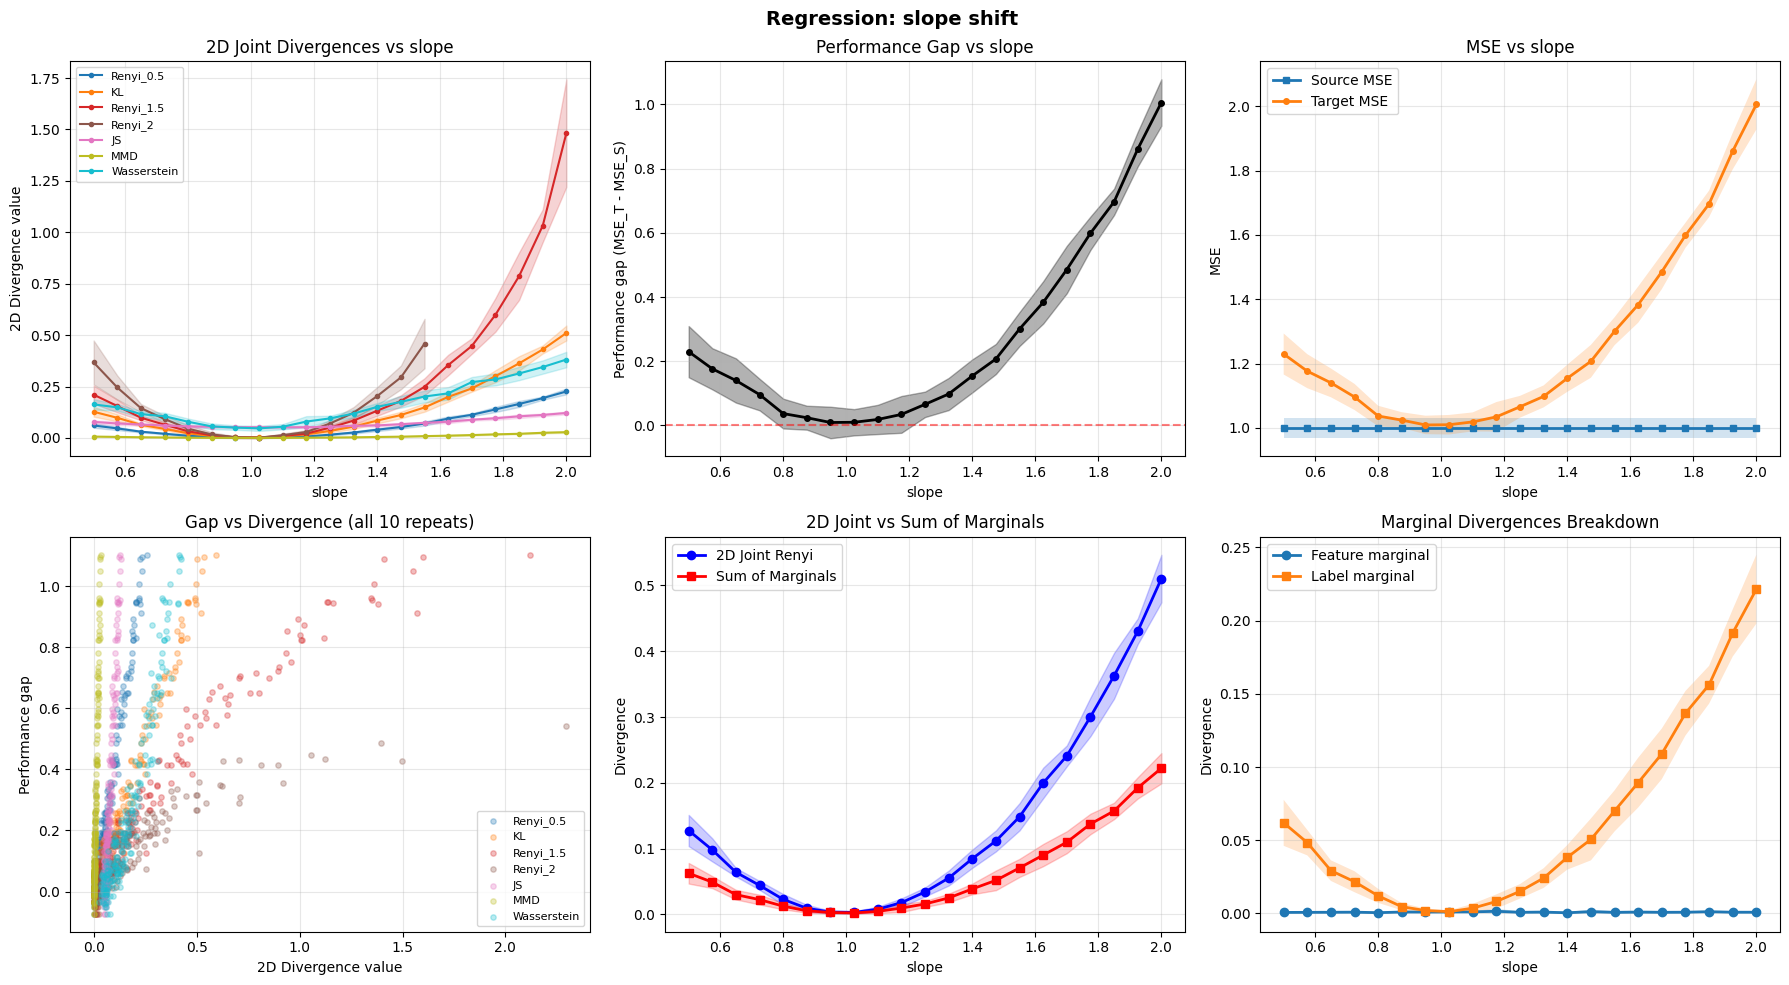


Sample results:
            gap        KL  Marginal_Sum
param                                  
0.500  0.229927  0.127603      0.062644
0.575  0.176497  0.098116      0.049131
0.650  0.140180  0.064149      0.030098
0.725  0.096272  0.044202      0.022573
0.800  0.037092  0.022885      0.012605
0.875  0.024266  0.009428      0.005610
0.950  0.009350  0.003688      0.003011
1.025  0.010033  0.003129      0.002321
1.100  0.018816  0.007991      0.004720
1.175  0.034486  0.017988      0.009706

EXPERIMENT 4: X Variance Shift - 10 repeats


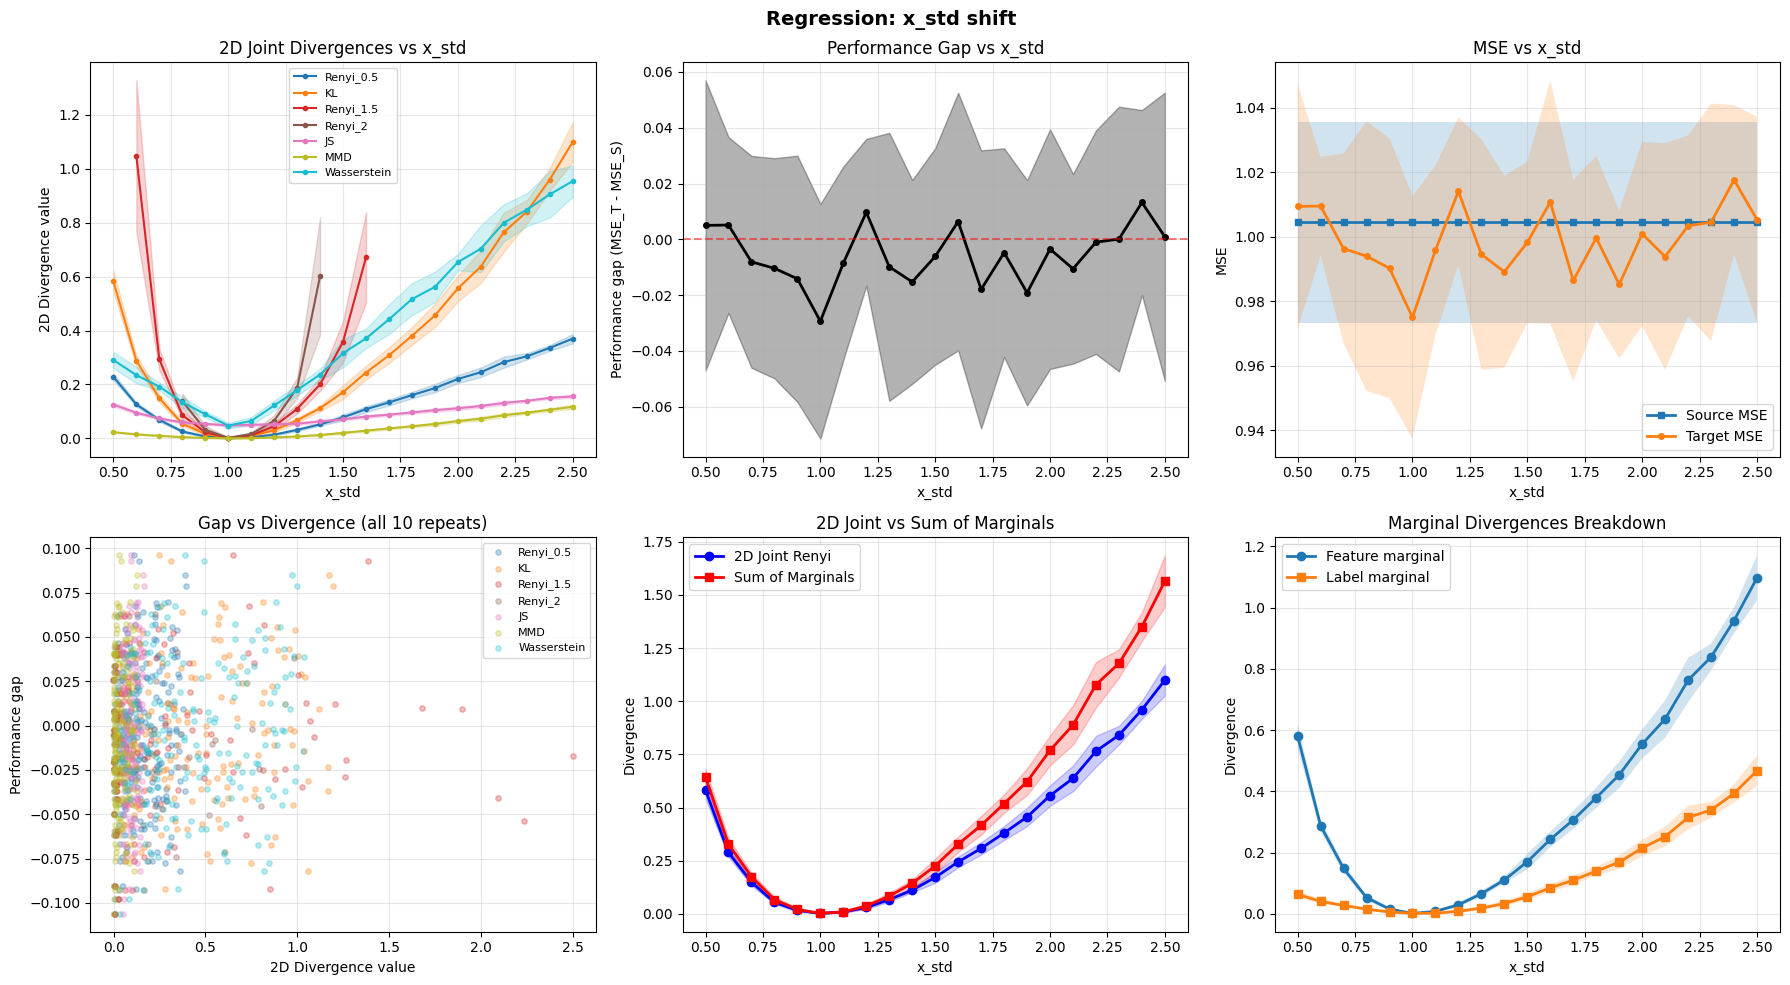


Sample results:
            gap        KL  Marginal_Sum
param                                  
0.5    0.004987  0.582348      0.643616
0.6    0.005097  0.288688      0.328038
0.7   -0.008095  0.148977      0.175023
0.8   -0.010408  0.054495      0.067581
0.9   -0.014179  0.016788      0.020942
1.0   -0.029403  0.002414      0.002524
1.1   -0.008579  0.009288      0.009486
1.2    0.009665  0.030415      0.037105
1.3   -0.009878  0.067021      0.083540
1.4   -0.015282  0.111817      0.143876

SUMMARY: Correlation between 2D divergences and performance gap

X shift:
  Renyi_0.5         : 0.0444
  KL                : -0.0437
  Renyi_1.5         : 0.0444
  Renyi_2           : 0.0444
  JS                : -0.0485
  MMD               : -0.0464
  Wasserstein       : -0.0518
  2D Joint          : -0.0437
  Marginal Sum      : -0.0440
  Difference        : 0.0003

Noise shift:
  Renyi_0.5         : 0.9435
  KL                : 0.9515
  Renyi_1.5         : nan
  Renyi_2           : nan
  JS    

/usr/local/lib/python3.12/dist-packages/numpy/lib/_function_base_impl.py:2767: RuntimeWarning: invalid value encountered in subtract
  X -= avg[:, None]


In [ ]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from scipy.stats import entropy, wasserstein_distance
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt

np.random.seed(42)

# ======================================================
# 1. Data generation
# ======================================================
def generate_regression_data(n, slope=1.0, intercept=0.0, noise_std=1.0, x_mean=0.0, x_std=1.0):
    """Generate regression data: y = slope * x + intercept + noise."""
    X = np.random.normal(x_mean, x_std, n)
    y = slope * X + intercept + np.random.normal(0, noise_std, n)
    return X.reshape(-1, 1), y

# ======================================================
# 2. Divergence functions for 2D (X, y) joint distributions
# ======================================================
def renyi_divergence_gaussian_2d(mu1, cov1, mu2, cov2, alpha=1.5):
    """Symmetric Rényi divergence for 2D Gaussian distributions.
    mu1, mu2: 2D mean vectors
    cov1, cov2: 2x2 covariance matrices
    Returns: 0.5 * (D_alpha(P||Q) + D_alpha(Q||P))
    """
    if alpha == 1.0:
        # Symmetric KL divergence for multivariate Gaussians
        k = len(mu1)

        cov2_inv = np.linalg.inv(cov2)
        cov1_inv = np.linalg.inv(cov1)

        diff = mu2 - mu1

        kl_pq = 0.5 * (np.trace(cov2_inv @ cov1) + diff.T @ cov2_inv @ diff - k +
                       np.log(np.linalg.det(cov2) / np.linalg.det(cov1)))
        kl_qp = 0.5 * (np.trace(cov1_inv @ cov2) + (-diff).T @ cov1_inv @ (-diff) - k +
                       np.log(np.linalg.det(cov1) / np.linalg.det(cov2)))

        return float(0.5 * (kl_pq + kl_qp))

    # For alpha != 1
    k = len(mu1)

    # Σ_α = α*Σ1 + (1-α)*Σ2
    cov_alpha_pq = alpha * cov1 + (1 - alpha) * cov2
    cov_alpha_qp = alpha * cov2 + (1 - alpha) * cov1

    det1, det2 = np.linalg.det(cov1), np.linalg.det(cov2)
    det_alpha_pq = np.linalg.det(cov_alpha_pq)
    det_alpha_qp = np.linalg.det(cov_alpha_qp)

    if det_alpha_pq <= 0 or det_alpha_qp <= 0:
        return float('inf')

    diff = mu1 - mu2
    cov_alpha_pq_inv = np.linalg.inv(cov_alpha_pq)
    cov_alpha_qp_inv = np.linalg.inv(cov_alpha_qp)

    term1_pq = 0.5 * np.log((det1**alpha * det2**(1-alpha)) / det_alpha_pq)
    term2_pq = (alpha * (1 - alpha) / 2) * (diff.T @ cov_alpha_pq_inv @ diff)
    renyi_pq = (term1_pq + term2_pq) / (alpha - 1)

    term1_qp = 0.5 * np.log((det2**alpha * det1**(1-alpha)) / det_alpha_qp)
    term2_qp = (alpha * (1 - alpha) / 2) * ((-diff).T @ cov_alpha_qp_inv @ (-diff))
    renyi_qp = (term1_qp + term2_qp) / (alpha - 1)

    return float(0.5 * (renyi_pq + renyi_qp))

def js_divergence_2d(xy1, xy2, bins=30):
    """Jensen-Shannon divergence for 2D data via histogram approximation."""
    # Create 2D histogram
    range_x = [min(xy1[:, 0].min(), xy2[:, 0].min()), max(xy1[:, 0].max(), xy2[:, 0].max())]
    range_y = [min(xy1[:, 1].min(), xy2[:, 1].min()), max(xy1[:, 1].max(), xy2[:, 1].max())]

    p_hist, x_edges, y_edges = np.histogram2d(xy1[:, 0], xy1[:, 1], bins=bins,
                                                range=[range_x, range_y], density=True)
    q_hist, _, _ = np.histogram2d(xy2[:, 0], xy2[:, 1], bins=[x_edges, y_edges],
                                   range=[range_x, range_y], density=True)

    # Flatten and normalize
    p_hist = p_hist.flatten()
    q_hist = q_hist.flatten()
    p_hist = p_hist / (p_hist.sum() + 1e-10)
    q_hist = q_hist / (q_hist.sum() + 1e-10)
    p_hist += 1e-10
    q_hist += 1e-10

    m = 0.5 * (p_hist + q_hist)
    return 0.5 * (entropy(p_hist, m) + entropy(q_hist, m))

def mmd_2d(xy1, xy2, sigma=1.0):
    """Maximum Mean Discrepancy for 2D data with RBF kernel."""
    Kxx = np.exp(-cdist(xy1, xy1, 'sqeuclidean') / (2 * sigma**2))
    Kyy = np.exp(-cdist(xy2, xy2, 'sqeuclidean') / (2 * sigma**2))
    Kxy = np.exp(-cdist(xy1, xy2, 'sqeuclidean') / (2 * sigma**2))
    mmd = np.mean(Kxx) + np.mean(Kyy) - 2 * np.mean(Kxy)
    return float(max(0, mmd))

def wasserstein_2d(xy1, xy2, n_projections=50):
    """Approximate 2D Wasserstein distance using sliced Wasserstein."""
    distances = []

    for _ in range(n_projections):
        # Random projection direction
        theta = np.random.uniform(0, 2 * np.pi)
        direction = np.array([np.cos(theta), np.sin(theta)])

        # Project data
        proj1 = xy1 @ direction
        proj2 = xy2 @ direction

        # Compute 1D Wasserstein
        distances.append(wasserstein_distance(proj1, proj2))

    return float(np.mean(distances))

def renyi_divergence_gaussian_1d(mu1, sigma1, mu2, sigma2, alpha=1.5):
    """1D Rényi divergence for comparison."""
    if alpha == 1.0:
        kl_pq = np.log(sigma2 / sigma1) + (sigma1**2 + (mu1 - mu2)**2) / (2 * sigma2**2) - 0.5
        kl_qp = np.log(sigma1 / sigma2) + (sigma2**2 + (mu2 - mu1)**2) / (2 * sigma1**2) - 0.5
        return float(0.5 * (kl_pq + kl_qp))

    sigma_alpha_sq_pq = (alpha * sigma1**2 + (1 - alpha) * sigma2**2)
    sigma_alpha_sq_qp = (alpha * sigma2**2 + (1 - alpha) * sigma1**2)

    if sigma_alpha_sq_pq <= 0 or sigma_alpha_sq_qp <= 0:
        return float('inf')

    term1_pq = 0.5 * np.log(sigma1**(2*alpha) * sigma2**(2*(1-alpha)) / sigma_alpha_sq_pq)
    term2_pq = (alpha * (1 - alpha) * (mu1 - mu2)**2) / (2 * sigma_alpha_sq_pq)
    renyi_pq = (term1_pq + term2_pq) / (alpha - 1)

    term1_qp = 0.5 * np.log(sigma2**(2*alpha) * sigma1**(2*(1-alpha)) / sigma_alpha_sq_qp)
    term2_qp = (alpha * (1 - alpha) * (mu2 - mu1)**2) / (2 * sigma_alpha_sq_qp)
    renyi_qp = (term1_qp + term2_qp) / (alpha - 1)

    return float(0.5 * (renyi_pq + renyi_qp))

def compute_divergences_regression(X_S, y_S, X_T, y_T):
    """Compute all divergence measures for regression (2D joint distribution)."""
    # Combine X and y into 2D points
    XY_S = np.column_stack([X_S.flatten(), y_S.flatten()])
    XY_T = np.column_stack([X_T.flatten(), y_T.flatten()])

    # Estimate 2D Gaussian parameters
    mu_S = XY_S.mean(axis=0)
    mu_T = XY_T.mean(axis=0)
    cov_S = np.cov(XY_S.T)
    cov_T = np.cov(XY_T.T)

    # 2D divergences (joint distribution)
    renyi_0_5 = renyi_divergence_gaussian_2d(mu_S, cov_S, mu_T, cov_T, alpha=0.5)
    renyi_1 = renyi_divergence_gaussian_2d(mu_S, cov_S, mu_T, cov_T, alpha=1.0)
    renyi_1_5 = renyi_divergence_gaussian_2d(mu_S, cov_S, mu_T, cov_T, alpha=1.5)
    renyi_2 = renyi_divergence_gaussian_2d(mu_S, cov_S, mu_T, cov_T, alpha=2.0)
    js_2d = js_divergence_2d(XY_S, XY_T)
    mmd_2d_val = mmd_2d(XY_S, XY_T, sigma=2.0)
    wass_2d = wasserstein_2d(XY_S, XY_T)

    # Also compute marginal divergences for comparison
    Z_S, Z_T = X_S.flatten(), X_T.flatten()
    y_S_flat, y_T_flat = y_S.flatten(), y_T.flatten()

    feat_renyi_1 = renyi_divergence_gaussian_1d(Z_S.mean(), Z_S.std(), Z_T.mean(), Z_T.std(), alpha=1.0)
    label_renyi_1 = renyi_divergence_gaussian_1d(y_S_flat.mean(), y_S_flat.std(),
                                                   y_T_flat.mean(), y_T_flat.std(), alpha=1.0)

    return {
        # 2D joint divergences
        "Renyi_0.5": renyi_0_5,
        "KL": renyi_1,
        "Renyi_1.5": renyi_1_5,
        "Renyi_2": renyi_2,
        "JS": js_2d,
        "MMD": mmd_2d_val,
        "Wasserstein": wass_2d,

        # Marginal divergences for comparison
        "Feat_Renyi_1": feat_renyi_1,
        "Label_Renyi_1": label_renyi_1,
        "Marginal_Sum": feat_renyi_1 + label_renyi_1
    }

# ======================================================
# 3. Regression experiments
# ======================================================
def run_regression_x_shift_experiment(n_repeats=10):
    """Vary X distribution (mean shift) for regression."""
    n = 2000
    slope, intercept, noise_std = 1.0, 0.0, 1.0
    x_mean_S, x_std = 0.0, 1.0

    x_shifts = np.linspace(-3, 3, 31)
    results = []

    for repeat in range(n_repeats):
        X_S, y_S = generate_regression_data(n, slope, intercept, noise_std, x_mean_S, x_std)
        reg = LinearRegression().fit(X_S, y_S)
        mse_S = mean_squared_error(y_S, reg.predict(X_S))

        for x_shift in x_shifts:
            X_T, y_T = generate_regression_data(n, slope, intercept, noise_std, x_mean_S + x_shift, x_std)
            mse_T = mean_squared_error(y_T, reg.predict(X_T))
            gap = mse_T - mse_S  # For regression, gap is increase in MSE

            divs = compute_divergences_regression(X_S, y_S, X_T, y_T)

            results.append({
                "repeat": repeat,
                "param": x_shift,
                "param_name": "x_shift",
                "mse_S": mse_S,
                "mse_T": mse_T,
                "gap": gap,
                **divs
            })

    return pd.DataFrame(results)

def run_regression_noise_shift_experiment(n_repeats=10):
    """Vary noise level for regression."""
    n = 2000
    slope, intercept = 1.0, 0.0
    x_mean, x_std = 0.0, 1.0
    noise_std_S = 1.0

    noise_stds_T = np.linspace(0.5, 2.5, 21)
    results = []

    for repeat in range(n_repeats):
        X_S, y_S = generate_regression_data(n, slope, intercept, noise_std_S, x_mean, x_std)
        reg = LinearRegression().fit(X_S, y_S)
        mse_S = mean_squared_error(y_S, reg.predict(X_S))

        for noise_std_T in noise_stds_T:
            X_T, y_T = generate_regression_data(n, slope, intercept, noise_std_T, x_mean, x_std)
            mse_T = mean_squared_error(y_T, reg.predict(X_T))
            gap = mse_T - mse_S

            divs = compute_divergences_regression(X_S, y_S, X_T, y_T)

            results.append({
                "repeat": repeat,
                "param": noise_std_T,
                "param_name": "noise_std",
                "mse_S": mse_S,
                "mse_T": mse_T,
                "gap": gap,
                **divs
            })

    return pd.DataFrame(results)

def run_regression_slope_shift_experiment(n_repeats=10):
    """Vary relationship slope for regression (concept drift)."""
    n = 2000
    slope_S, intercept, noise_std = 1.0, 0.0, 1.0
    x_mean, x_std = 0.0, 1.0

    slopes_T = np.linspace(0.5, 2.0, 21)
    results = []

    for repeat in range(n_repeats):
        X_S, y_S = generate_regression_data(n, slope_S, intercept, noise_std, x_mean, x_std)
        reg = LinearRegression().fit(X_S, y_S)
        mse_S = mean_squared_error(y_S, reg.predict(X_S))

        for slope_T in slopes_T:
            X_T, y_T = generate_regression_data(n, slope_T, intercept, noise_std, x_mean, x_std)
            mse_T = mean_squared_error(y_T, reg.predict(X_T))
            gap = mse_T - mse_S

            divs = compute_divergences_regression(X_S, y_S, X_T, y_T)

            results.append({
                "repeat": repeat,
                "param": slope_T,
                "param_name": "slope",
                "mse_S": mse_S,
                "mse_T": mse_T,
                "gap": gap,
                **divs
            })

    return pd.DataFrame(results)

def run_regression_x_variance_shift_experiment(n_repeats=10):
    """Vary X variance for regression."""
    n = 2000
    slope, intercept, noise_std = 1.0, 0.0, 1.0
    x_mean, x_std_S = 0.0, 1.0

    x_stds_T = np.linspace(0.5, 2.5, 21)
    results = []

    for repeat in range(n_repeats):
        X_S, y_S = generate_regression_data(n, slope, intercept, noise_std, x_mean, x_std_S)
        reg = LinearRegression().fit(X_S, y_S)
        mse_S = mean_squared_error(y_S, reg.predict(X_S))

        for x_std_T in x_stds_T:
            X_T, y_T = generate_regression_data(n, slope, intercept, noise_std, x_mean, x_std_T)
            mse_T = mean_squared_error(y_T, reg.predict(X_T))
            gap = mse_T - mse_S

            divs = compute_divergences_regression(X_S, y_S, X_T, y_T)

            results.append({
                "repeat": repeat,
                "param": x_std_T,
                "param_name": "x_std",
                "mse_S": mse_S,
                "mse_T": mse_T,
                "gap": gap,
                **divs
            })

    return pd.DataFrame(results)

# ======================================================
# 4. Visualization
# ======================================================
def plot_regression_results(df, title_suffix=""):
    """Create comprehensive plots for regression experiments with error bars."""
    param_name = df['param_name'].iloc[0]

    # Aggregate statistics across repeats
    metric_cols = ['mse_S', 'mse_T', 'gap', 'Renyi_0.5', 'KL',
                   'Renyi_1.5', 'Renyi_2', 'JS', 'MMD', 'Wasserstein',
                   'Feat_Renyi_1', 'Label_Renyi_1', 'Marginal_Sum']
    df_agg = df.groupby('param')[metric_cols].agg(['mean', 'std']).reset_index()

    fig, axes = plt.subplots(2, 3, figsize=(18, 10))

    div_measures = ["Renyi_0.5", "KL", "Renyi_1.5", "Renyi_2", "JS", "MMD", "Wasserstein"]
    colors = plt.cm.tab10(np.linspace(0, 1, len(div_measures)))

    param_values = df_agg['param'].values

    # Plot 1: 2D Divergence vs parameter
    ax = axes[0, 0]
    for div, color in zip(div_measures, colors):
        mean_vals = df_agg[div]['mean'].values
        std_vals = df_agg[div]['std'].values
        ax.plot(param_values, mean_vals, label=div, marker='o', markersize=3, color=color)
        ax.fill_between(param_values, mean_vals - std_vals, mean_vals + std_vals,
                        alpha=0.2, color=color)
    ax.set_xlabel(f'{param_name}')
    ax.set_ylabel('2D Divergence value')
    ax.set_title(f'2D Joint Divergences vs {param_name}')
    ax.legend(fontsize=8)
    ax.grid(True, alpha=0.3)

    # Plot 2: Performance gap vs parameter
    ax = axes[0, 1]
    gap_mean = df_agg['gap']['mean'].values
    gap_std = df_agg['gap']['std'].values
    ax.plot(param_values, gap_mean, marker='o', markersize=4, color='black', linewidth=2)
    ax.fill_between(param_values, gap_mean - gap_std, gap_mean + gap_std,
                    alpha=0.3, color='black')
    ax.axhline(y=0, color='r', linestyle='--', alpha=0.5)
    ax.set_xlabel(f'{param_name}')
    ax.set_ylabel('Performance gap (MSE_T - MSE_S)')
    ax.set_title(f'Performance Gap vs {param_name}')
    ax.grid(True, alpha=0.3)

    # Plot 3: Source vs Target MSE
    ax = axes[0, 2]
    mse_s_mean = df_agg['mse_S']['mean'].values
    mse_s_std = df_agg['mse_S']['std'].values
    mse_t_mean = df_agg['mse_T']['mean'].values
    mse_t_std = df_agg['mse_T']['std'].values

    ax.plot(param_values, mse_s_mean, label='Source MSE', marker='s', markersize=4, linewidth=2)
    ax.fill_between(param_values, mse_s_mean - mse_s_std, mse_s_mean + mse_s_std, alpha=0.2)
    ax.plot(param_values, mse_t_mean, label='Target MSE', marker='o', markersize=4, linewidth=2)
    ax.fill_between(param_values, mse_t_mean - mse_t_std, mse_t_mean + mse_t_std, alpha=0.2)
    ax.set_xlabel(f'{param_name}')
    ax.set_ylabel('MSE')
    ax.set_title(f'MSE vs {param_name}')
    ax.legend()
    ax.grid(True, alpha=0.3)

    # Plot 4: Divergence vs gap scatter (all repeats)
    ax = axes[1, 0]
    for div, color in zip(div_measures, colors):
        ax.scatter(df[div], df['gap'], label=div, alpha=0.3, s=15, color=color)
    ax.set_xlabel('2D Divergence value')
    ax.set_ylabel('Performance gap')
    ax.set_title(f'Gap vs Divergence (all {df["repeat"].max()+1} repeats)')
    ax.legend(fontsize=8)
    ax.grid(True, alpha=0.3)

    # Plot 5: Joint vs Marginal comparison
    ax = axes[1, 1]
    joint_mean = df_agg['KL']['mean'].values
    joint_std = df_agg['KL']['std'].values
    marginal_mean = df_agg['Marginal_Sum']['mean'].values
    marginal_std = df_agg['Marginal_Sum']['std'].values

    ax.plot(param_values, joint_mean, label='2D Joint Renyi', marker='o', linewidth=2, color='blue')
    ax.fill_between(param_values, joint_mean - joint_std, joint_mean + joint_std, alpha=0.2, color='blue')
    ax.plot(param_values, marginal_mean, label='Sum of Marginals', marker='s', linewidth=2, color='red')
    ax.fill_between(param_values, marginal_mean - marginal_std, marginal_mean + marginal_std, alpha=0.2, color='red')
    ax.set_xlabel(f'{param_name}')
    ax.set_ylabel('Divergence')
    ax.set_title('2D Joint vs Sum of Marginals')
    ax.legend()
    ax.grid(True, alpha=0.3)

    # Plot 6: Marginal breakdown
    ax = axes[1, 2]
    feat_mean = df_agg['Feat_Renyi_1']['mean'].values
    feat_std = df_agg['Feat_Renyi_1']['std'].values
    label_mean = df_agg['Label_Renyi_1']['mean'].values
    label_std = df_agg['Label_Renyi_1']['std'].values

    ax.plot(param_values, feat_mean, label='Feature marginal', marker='o', linewidth=2)
    ax.fill_between(param_values, feat_mean - feat_std, feat_mean + feat_std, alpha=0.2)
    ax.plot(param_values, label_mean, label='Label marginal', marker='s', linewidth=2)
    ax.fill_between(param_values, label_mean - label_std, label_mean + label_std, alpha=0.2)
    ax.set_xlabel(f'{param_name}')
    ax.set_ylabel('Divergence')
    ax.set_title('Marginal Divergences Breakdown')
    ax.legend()
    ax.grid(True, alpha=0.3)

    plt.suptitle(f'Regression: {param_name} shift {title_suffix}', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

# ======================================================
# 5. Run all regression experiments
# ======================================================
n_repeats = 10

print("="*80)
print("REGRESSION EXPERIMENTS - 2D DIVERGENCE ANALYSIS")
print("="*80)

print("\n" + "="*80)
print(f"EXPERIMENT 1: X Shift (Covariate Shift) - {n_repeats} repeats")
print("="*80)
df_reg_x = run_regression_x_shift_experiment(n_repeats=n_repeats)
plot_regression_results(df_reg_x)
print("\nSample results:")
print(df_reg_x.groupby('param')[['gap', 'KL', 'Marginal_Sum']].mean().head(10))

print("\n" + "="*80)
print(f"EXPERIMENT 2: Noise Shift - {n_repeats} repeats")
print("="*80)
df_reg_noise = run_regression_noise_shift_experiment(n_repeats=n_repeats)
plot_regression_results(df_reg_noise)
print("\nSample results:")
print(df_reg_noise.groupby('param')[['gap', 'KL', 'Marginal_Sum']].mean().head(10))

print("\n" + "="*80)
print(f"EXPERIMENT 3: Slope Shift (Concept Drift) - {n_repeats} repeats")
print("="*80)
df_reg_slope = run_regression_slope_shift_experiment(n_repeats=n_repeats)
plot_regression_results(df_reg_slope)
print("\nSample results:")
print(df_reg_slope.groupby('param')[['gap', 'KL', 'Marginal_Sum']].mean().head(10))

print("\n" + "="*80)
print(f"EXPERIMENT 4: X Variance Shift - {n_repeats} repeats")
print("="*80)
df_reg_x_var = run_regression_x_variance_shift_experiment(n_repeats=n_repeats)
plot_regression_results(df_reg_x_var)
print("\nSample results:")
print(df_reg_x_var.groupby('param')[['gap', 'KL', 'Marginal_Sum']].mean().head(10))

# Summary comparison
print("\n" + "="*80)
print("SUMMARY: Correlation between 2D divergences and performance gap")
print("="*80)
div_measures = ["Renyi_0.5", "KL", "Renyi_1.5", "Renyi_2", "JS", "MMD", "Wasserstein"]

for exp_name, df in [("X shift", df_reg_x),
                      ("Noise shift", df_reg_noise),
                      ("Slope shift", df_reg_slope),
                      ("X variance shift", df_reg_x_var)]:
    print(f"\n{exp_name}:")
    for div in div_measures:
        corr = df[div].corr(df['gap'].abs())
        print(f"  {div:18s}: {corr:.4f}")

    # Compare joint vs marginal
    corr_joint = df['KL'].corr(df['gap'].abs())
    corr_marginal = df['Marginal_Sum'].corr(df['gap'].abs())
    print(f"  {'2D Joint':18s}: {corr_joint:.4f}")
    print(f"  {'Marginal Sum':18s}: {corr_marginal:.4f}")
    print(f"  {'Difference':18s}: {corr_joint - corr_marginal:.4f}")